In [1]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
import hera_cal.abscal as abscal
import uvtools.dspec as dspec 
import hera_pspec
from hera_pspec import pspecbeam
from hera_pspec import pspecdata
import itertools
import scipy 
from scipy import signal
import pickle
import copy
from hera_cal.utils import polnum2str, polstr2num, jnum2str, jstr2num
from hera_cal.io import HERAData, HERACal
from hera_cal.io import DataContainer 
from hera_cal import apply_cal
from hera_cal import io
from hera_cal import smooth_cal
from hera_cal import vis_clean
from hera_cal import redcal
from pyuvdata import UVFlag
import glob
import tqdm
import os
import shutil

/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next maj

In [2]:
%config Completer.use_jedi = False

In [3]:
#Scale Plot/Figure Sizes

plt.rcParams['figure.figsize'] = 20,10
plt.rcParams['font.size'] = 20

In [4]:
#Discrete Fourier Transform 

def fft(x):
    return np.abs(np.fft.fftshift(np.fft.fft(np.fft.fftshift(x))))

In [5]:
flag_files = [f"H1C_Flags/{jd}.flags.h5" for jd in [2458098,2458099, 2458101, 2458102, 2458103, 2458106, 2458107,
                                                   2458108, 2458110, 2458111]]
model_files = sorted(glob.glob('/lustre/aoc/projects/hera/aewallwi/time_dep_flagging/2458098/*.true.uvh5'))
data_files = sorted(glob.glob('/lustre/aoc/projects/hera/aewallwi/time_dep_flagging/2458098/*.true.uvh5'))

In [6]:
ntimes = []
for flags in flag_files:
    uvf = UVFlag(flags)
    ntimes.append(uvf.Ntimes)
nflagstimes = np.min(ntimes)

In [12]:
np.diff(flags.freq_array)

array([97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656

In [13]:
np.diff(hd_data.freqs)

array([97751.71065493, 97751.71065494, 97751.71065494, ...,
       97751.71065497, 97751.71065488, 97751.71065497])

In [26]:
len(data_files[:])

32

In [28]:
#For-Loop Calibration
nfiles = []
for day,flag_file in enumerate(flag_files):
    if not os.path.exists(f'HERA_CLEAN_NOPRISIM_{day}'):
        os.mkdir(f'HERA_CLEAN_NOPRISIM_{day}')
    flags = UVFlag(flag_file)
    flags.select(frequencies = flags.freq_array[(flags.freq_array>=130*1e+6) & (flags.freq_array<170*1e+6)])
    flags_chunks = [flags.flag_array.squeeze()[i*60:(i+1)*60] for i in range(nflagstimes//60)]
    file_number=0
    for data_file,model_file,flags_chunk in tqdm.tqdm(zip(data_files, model_files, flags_chunks)):
        #Opening Data/Flags
        hd_data = HERAData(data_file)     
        freqs = hd_data.freqs[(hd_data.freqs>=130*1e+6) & (hd_data.freqs<170*1e+6)][:-1]
        d_data, d_flags, d_nsamples = hd_data.read(polarizations=['nn'], frequencies=freqs)
        for bl in d_data:
            d_flags[bl] = flags_chunk
        hd_data.update(flags=d_flags)
        hd_data.write_uvh5(f"HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}.uvh5", clobber=True)
        del d_data,d_flags,d_nsamples,hd_data
        #Calculate Gains/Smooth
        redcal.redcal_run(input_data=f'HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}.uvh5',
                          clobber=True, solar_horizon=90, verbose=True)
        abscal.post_redcal_abscal_run(data_file = f'HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}.uvh5',
                                      redcal_file = f'HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}.omni.calfits',
                                      model_files = [f'HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}.uvh5'],
                                      clobber=True, data_solar_horizon=90,
                                      model_solar_horizon=90)
        file_number += 1
    nfiles.append(file_number)
    cs = smooth_cal.CalibrationSmoother(calfits_list=sorted(glob.glob(f'HERA_CLEAN_NOPRISIM_{day}/data_{day}_*.abs.calfits')))
    cs.time_freq_2D_filter(time_scale=21600)
    cs.write_smoothed_cal(clobber=True,output_replace=('.abs.','.smooth_abs.'))
    
    for file_number in tqdm.tqdm(range(nfiles[-1])): 
        #Apply Smooth Gains
        apply_cal.apply_cal(data_infilename=f'HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}.uvh5',
                            data_outfilename=f'HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}_smoothcal.uvh5',
                            new_calibration=f'HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}.smooth_abs.calfits', clobber=True)
        #Fourier-Filter
        vc = vis_clean.VisClean(f"HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}_smoothcal.uvh5")
        vc.read()
        vc.vis_clean(standoff=100, min_dly=300, mode='dpss_leastsq', skip_if_flag_within_edge_distance=1, 
                     flag_model_rms_outliers=True, max_contiguous_edge_flags=1)
        vc.write_filtered_data(filled_outfilename=f'HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}_filtered.uvh5',clobber=True)
        os.remove(f'HERA_CLEAN_NOPRISIM_{day}/data_{day}_{file_number}.uvh5')

0it [00:00, ?it/s]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2672558525 through 2458098.2745881174 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_0.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_0.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_0.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_0.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_0.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.2672558525 through 2458098.2745881174...


Mean of empty slice.
invalid value encountered in double_scalars
1it [02:02, 122.82s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.274712393 through 2458098.282044658 ...
Throwing out antenna 41 for a z-score of 4.49510043114633 on polarization Jnn.

Throwing out antenna 50 for a z-score of 4.122412028469345 on polarization Jnn.


Now running redundant calibration without antennas [41, 50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.274712393 through 2458098.282044658 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_1.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_1.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_1.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_1.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_1.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.274712393 through 2458098.282044658...


Mean of empty slice.
invalid value encountered in double_scalars
2it [05:10, 160.87s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2821689337 through 2458098.289501198 ...
Throwing out antenna 41 for a z-score of 6.317805666173073 on polarization Jnn.

Throwing out antenna 50 for a z-score of 6.162510751050641 on polarization Jnn.


Now running redundant calibration without antennas [41, 50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2821689337 through 2458098.289501198 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_2.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_2.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_2.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_2.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_2.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.2821689337 through 2458098.289501198...


Mean of empty slice.
invalid value encountered in double_scalars
3it [08:32, 179.61s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.289625474 through 2458098.2969577387 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_3.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_3.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_3.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_3.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_3.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.289625474 through 2458098.2969577387...


Mean of empty slice.
invalid value encountered in double_scalars
4it [10:34, 156.79s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2970820144 through 2458098.3044142793 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_4.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_4.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_4.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_4.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_4.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.2970820144 through 2458098.3044142793...


Mean of empty slice.
invalid value encountered in double_scalars
5it [12:35, 143.92s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.304538555 through 2458098.3118708194 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_5.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_5.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_5.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_5.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_5.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.304538555 through 2458098.3118708194...


Mean of empty slice.
invalid value encountered in double_scalars
6it [14:31, 134.54s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.311995095 through 2458098.31932736 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_6.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_6.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_6.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_6.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_6.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.311995095 through 2458098.31932736...


Mean of empty slice.
invalid value encountered in double_scalars
7it [16:25, 127.77s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3194516357 through 2458098.3267839006 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_7.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_7.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_7.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_7.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_7.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3194516357 through 2458098.3267839006...


Mean of empty slice.
invalid value encountered in double_scalars
8it [18:21, 124.15s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3269081763 through 2458098.3342404407 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_8.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_8.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_8.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_8.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_8.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3269081763 through 2458098.3342404407...


Mean of empty slice.
invalid value encountered in double_scalars
9it [20:12, 119.87s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3343647164 through 2458098.3416969813 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_9.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_9.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_9.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_9.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_9.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3343647164 through 2458098.3416969813...


Mean of empty slice.
invalid value encountered in double_scalars
10it [22:00, 116.38s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.341821257 through 2458098.349153522 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_10.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_10.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_10.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_10.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_10.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.341821257 through 2458098.349153522...


Mean of empty slice.
invalid value encountered in double_scalars
11it [23:49, 113.99s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3492777976 through 2458098.356610062 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_11.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_11.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_11.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_11.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_11.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3492777976 through 2458098.356610062...


Mean of empty slice.
invalid value encountered in double_scalars
12it [25:45, 114.52s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3567343378 through 2458098.3640666027 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_12.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_12.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_12.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_12.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_12.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3567343378 through 2458098.3640666027...


Mean of empty slice.
invalid value encountered in double_scalars
13it [27:46, 116.66s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3641908783 through 2458098.3715231433 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_13.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_13.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_13.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_13.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_13.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3641908783 through 2458098.3715231433...


Mean of empty slice.
invalid value encountered in double_scalars
14it [30:05, 123.44s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.371647419 through 2458098.3789796834 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_14.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_14.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_14.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_14.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_14.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.371647419 through 2458098.3789796834...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 9.990512067237087e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 5.530649064537843e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
15it [33:12, 142.52s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.379103959 through 2458098.386436224 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_15.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_15.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_15.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_15.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_15.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.379103959 through 2458098.386436224...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.2011536607951802e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 6.956902055619878e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
16it [36:04, 151.47s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3865604997 through 2458098.3938927646 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_16.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_16.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_16.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_16.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_16.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3865604997 through 2458098.3938927646...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.2482324475161822e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 6.997436607947286e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
17it [39:01, 159.15s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3940170403 through 2458098.4013493047 ...
Throwing out antenna 50 for a z-score of 5.148202634416599 on polarization Jnn.


Now running redundant calibration without antennas [50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3940170403 through 2458098.4013493047 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_17.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_17.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_17.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_17.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_17.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3940170403 through 2458098.4013493047...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 7.749495359951382e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.858141168687792e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
18it [43:18, 188.56s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4014735804 through 2458098.4088058453 ...
Throwing out antenna 50 for a z-score of 5.244614270289224 on polarization Jnn.


Now running redundant calibration without antennas [50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4014735804 through 2458098.4088058453 ...
Throwing out antenna 27 for a z-score of 4.319562937027436 on polarization Jnn.

Throwing out antenna 41 for a z-score of 6.163069031688174 on polarization Jnn.

Throwing out antenna 66 for a z-score of 5.138574004809498 on polarization Jnn.


Now running redundant calibration without antennas [41, 50, 27, 66] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4014735804 through 2458098.4088058453 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_18.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/dat

Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_18.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_18.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4014735804 through 2458098.4088058453...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 4.975482741533604e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 3.597457023625765e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
19it [48:41, 228.87s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.408930121 through 2458098.416262386 ...
Throwing out antenna 50 for a z-score of 4.062968358381742 on polarization Jnn.


Now running redundant calibration without antennas [50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.408930121 through 2458098.416262386 ...
Throwing out antenna 41 for a z-score of 5.396096141016326 on polarization Jnn.

Throwing out antenna 66 for a z-score of 4.462823248530585 on polarization Jnn.


Now running redundant calibration without antennas [41, 50, 66] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.408930121 through 2458098.416262386 ...
Throwing out antenna 27 for a z-score of 4.288810583516626 on polarization Jnn.

Throwing out antenna 36 for a z-score of 5.501769698537974 on polarization Jnn.

Throwing out antenna 55 for a z-score of 4.86633536033122 

Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_19.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_19.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.408930121 through 2458098.416262386...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.058464423120452e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 6.221344673309998e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
20it [55:11, 277.37s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4163866616 through 2458098.423718926 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_20.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_20.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_20.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_20.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_20.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4163866616 through 2458098.423718926...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 6.219615470413e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.4030699590568223e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
21it [58:05, 246.14s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4238432017 through 2458098.4311754666 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_21.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_21.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_21.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_21.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_21.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4238432017 through 2458098.4311754666...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 7.436316266673788e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.518443327598922e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
22it [1:00:59, 224.61s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4312997423 through 2458098.438632007 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_22.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_22.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_22.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_22.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_22.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4312997423 through 2458098.438632007...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.6344492703264503e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 2.57866881338215e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
23it [1:04:05, 213.00s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.438756283 through 2458098.4460885474 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_23.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_23.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_23.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_23.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_23.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.438756283 through 2458098.4460885474...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 7.534053366253202e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.951196020139964e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
24it [1:07:16, 206.45s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.446212823 through 2458098.453545088 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_24.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_24.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_24.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_24.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_24.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.446212823 through 2458098.453545088...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 5.93455565720403e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.0299988831693135e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
25it [1:10:15, 198.17s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4536693636 through 2458098.4610016285 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_25.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_25.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_25.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_25.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_25.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4536693636 through 2458098.4610016285...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 5.5004276054171265e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.2076660838223004e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
26it [1:13:10, 191.21s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.461125904 through 2458098.4684581687 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_26.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_26.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_26.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_26.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_26.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.461125904 through 2458098.4684581687...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.6807950381128533e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 1.4145268348453203e-15
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
27it [1:16:06, 186.62s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4685824444 through 2458098.4759147093 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_27.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_27.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_27.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_27.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_27.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4685824444 through 2458098.4759147093...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 8.422970156291275e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.640669700390448e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
28it [1:19:03, 183.85s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.476038985 through 2458098.48337125 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_28.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_28.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_28.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_28.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_28.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.476038985 through 2458098.48337125...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.726611467470199e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 1.9403664079328696e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
29it [1:21:56, 180.60s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4834955256 through 2458098.49082779 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_29.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_29.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_29.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_29.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_29.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4834955256 through 2458098.49082779...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 8.060059960033384e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.441932702008258e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
30it [1:24:58, 180.92s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4909520657 through 2458098.4982843306 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_30.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_30.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_30.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_30.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_30.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4909520657 through 2458098.4982843306...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 4.862575132806644e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 3.540982497328688e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
31it [1:28:04, 182.56s/it]Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4984086063 through 2458098.505740871 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_0/data_0_31.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_0/data_0_31.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_0/data_0_31.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_0/data_0_31.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_0/data_0_31.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4984086063 through 2458098.505740871...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.7157724636212743e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 1.5908824468681905e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
32it [1:31:00, 170.63s/it]
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
  0%|   

File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


  3%|▎         | 1/32 [00:21<11:18, 21.90s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_0_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
  6%|▋         | 2/32 [00:38<09:24, 18.82s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_1_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
  9%|▉         | 3/32 [00:56<08:53, 18.40s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_2_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 12%|█▎        | 4/32 [01:12<08:05, 17.35s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_3_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 16%|█▌        | 5/32 [01:33<08:22, 18.62s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_4_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 19%|█▉        | 6/32 [01:48<07:37, 17.58s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_5_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 22%|██▏       | 7/32 [02:05<07:13, 17.35s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_6_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 25%|██▌       | 8/32 [02:23<06:59, 17.46s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_7_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 28%|██▊       | 9/32 [02:36<06:14, 16.30s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_8_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 31%|███▏      | 10/32 [02:55<06:12, 16.94s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_9_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...writing to HERA_CLEAN_NOPRISIM_0/data_0_10_filtered.uvh5


 34%|███▍      | 11/32 [03:12<06:00, 17.16s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 38%|███▊      | 12/32 [03:35<06:18, 18.93s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_11_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 41%|████      | 13/32 [03:52<05:46, 18.24s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_12_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 44%|████▍     | 14/32 [04:30<07:16, 24.28s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_13_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 47%|████▋     | 15/32 [05:45<11:08, 39.34s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_14_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 50%|█████     | 16/32 [07:32<15:54, 59.68s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_15_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 53%|█████▎    | 17/32 [09:18<18:26, 73.79s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_16_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 56%|█████▋    | 18/32 [11:01<19:14, 82.49s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_17_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...writing to HERA_CLEAN_NOPRISIM_0/data_0_18_filtered.uvh5


 59%|█████▉    | 19/32 [12:34<18:32, 85.59s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 62%|██████▎   | 20/32 [13:52<16:41, 83.43s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_19_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 66%|██████▌   | 21/32 [15:43<16:47, 91.57s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_20_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 69%|██████▉   | 22/32 [17:31<16:05, 96.59s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_21_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 72%|███████▏  | 23/32 [19:20<15:03, 100.44s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_22_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 75%|███████▌  | 24/32 [21:13<13:53, 104.15s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_23_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 78%|███████▊  | 25/32 [22:51<11:55, 102.23s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_24_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 81%|████████▏ | 26/32 [24:45<10:34, 105.75s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_25_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 84%|████████▍ | 27/32 [26:33<08:52, 106.47s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_26_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 88%|████████▊ | 28/32 [27:18<05:52, 88.04s/it] 

...writing to HERA_CLEAN_NOPRISIM_0/data_0_27_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 91%|█████████ | 29/32 [28:42<04:20, 86.96s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_28_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 94%|█████████▍| 30/32 [29:20<02:24, 72.16s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_29_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 97%|█████████▋| 31/32 [30:48<01:16, 76.84s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_30_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
100%|██████████| 32/32 [31:25<00:00, 58.92s/it]

...writing to HERA_CLEAN_NOPRISIM_0/data_0_31_filtered.uvh5



0it [00:00, ?it/s]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2672558525 through 2458098.2745881174 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_0.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_0.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_0.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_0.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_0.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.2672558525 through 2458098.2745881174...


Mean of empty slice.
invalid value encountered in double_scalars
1it [01:52, 112.76s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.274712393 through 2458098.282044658 ...
Throwing out antenna 41 for a z-score of 4.49510043114633 on polarization Jnn.

Throwing out antenna 50 for a z-score of 4.122412028469345 on polarization Jnn.


Now running redundant calibration without antennas [41, 50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.274712393 through 2458098.282044658 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_1.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_1.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_1.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_1.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_1.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.274712393 through 2458098.282044658...


Mean of empty slice.
invalid value encountered in double_scalars
2it [05:02, 158.15s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2821689337 through 2458098.289501198 ...
Throwing out antenna 41 for a z-score of 6.317805666173073 on polarization Jnn.

Throwing out antenna 50 for a z-score of 6.162510751050641 on polarization Jnn.


Now running redundant calibration without antennas [41, 50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2821689337 through 2458098.289501198 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_2.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_2.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_2.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_2.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_2.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.2821689337 through 2458098.289501198...


Mean of empty slice.
invalid value encountered in double_scalars
3it [08:09, 171.39s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.289625474 through 2458098.2969577387 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_3.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_3.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_3.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_3.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_3.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.289625474 through 2458098.2969577387...


Mean of empty slice.
invalid value encountered in double_scalars
4it [10:03, 148.41s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2970820144 through 2458098.3044142793 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_4.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_4.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_4.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_4.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_4.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.2970820144 through 2458098.3044142793...


Mean of empty slice.
invalid value encountered in double_scalars
5it [12:01, 137.64s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.304538555 through 2458098.3118708194 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_5.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_5.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_5.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_5.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_5.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.304538555 through 2458098.3118708194...


Mean of empty slice.
invalid value encountered in double_scalars
6it [13:49, 127.62s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.311995095 through 2458098.31932736 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_6.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_6.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_6.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_6.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_6.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.311995095 through 2458098.31932736...


Mean of empty slice.
invalid value encountered in double_scalars
7it [15:42, 122.72s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3194516357 through 2458098.3267839006 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_7.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_7.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_7.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_7.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_7.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3194516357 through 2458098.3267839006...


Mean of empty slice.
invalid value encountered in double_scalars
8it [17:35, 119.75s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3269081763 through 2458098.3342404407 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_8.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_8.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_8.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_8.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_8.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3269081763 through 2458098.3342404407...


Mean of empty slice.
invalid value encountered in double_scalars
9it [19:26, 116.90s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3343647164 through 2458098.3416969813 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_9.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_9.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_9.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_9.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_9.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3343647164 through 2458098.3416969813...


Mean of empty slice.
invalid value encountered in double_scalars
10it [21:14, 114.11s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.341821257 through 2458098.349153522 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_10.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_10.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_10.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_10.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_10.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.341821257 through 2458098.349153522...


Mean of empty slice.
invalid value encountered in double_scalars
11it [23:01, 112.02s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3492777976 through 2458098.356610062 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_11.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_11.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_11.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_11.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_11.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3492777976 through 2458098.356610062...


Mean of empty slice.
invalid value encountered in double_scalars
12it [24:54, 112.29s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3567343378 through 2458098.3640666027 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_12.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_12.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_12.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_12.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_12.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3567343378 through 2458098.3640666027...


Mean of empty slice.
invalid value encountered in double_scalars
13it [26:49, 113.12s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3641908783 through 2458098.3715231433 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_13.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_13.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_13.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_13.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_13.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3641908783 through 2458098.3715231433...


Mean of empty slice.
invalid value encountered in double_scalars
14it [28:53, 116.41s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.371647419 through 2458098.3789796834 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_14.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_14.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_14.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_14.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_14.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.371647419 through 2458098.3789796834...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 7.274123142557572e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.2923614348798217e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
15it [31:59, 137.44s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.379103959 through 2458098.386436224 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_15.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_15.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_15.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_15.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_15.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.379103959 through 2458098.386436224...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 8.169727507987783e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.882262674871034e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
16it [35:00, 150.37s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3865604997 through 2458098.3938927646 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_16.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_16.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_16.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_16.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_16.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3865604997 through 2458098.3938927646...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.0590074022982334e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 6.070413185287622e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
17it [37:53, 157.29s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3940170403 through 2458098.4013493047 ...
Throwing out antenna 50 for a z-score of 5.148202634416599 on polarization Jnn.


Now running redundant calibration without antennas [50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3940170403 through 2458098.4013493047 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_17.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_17.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_17.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_17.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_17.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3940170403 through 2458098.4013493047...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.5894246353015236e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 3.042197576381363e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
18it [42:09, 186.91s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4014735804 through 2458098.4088058453 ...
Throwing out antenna 50 for a z-score of 5.244614270289224 on polarization Jnn.


Now running redundant calibration without antennas [50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4014735804 through 2458098.4088058453 ...
Throwing out antenna 27 for a z-score of 4.319562937027436 on polarization Jnn.

Throwing out antenna 41 for a z-score of 6.163069031688174 on polarization Jnn.

Throwing out antenna 66 for a z-score of 5.138574004809498 on polarization Jnn.


Now running redundant calibration without antennas [41, 50, 27, 66] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4014735804 through 2458098.4088058453 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_18.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/dat

Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_18.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_18.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4014735804 through 2458098.4088058453...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 6.160092990922994e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.3442092857377863e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
19it [47:26, 226.03s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.408930121 through 2458098.416262386 ...
Throwing out antenna 50 for a z-score of 4.062968358381742 on polarization Jnn.


Now running redundant calibration without antennas [50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.408930121 through 2458098.416262386 ...
Throwing out antenna 41 for a z-score of 5.396096141016326 on polarization Jnn.

Throwing out antenna 66 for a z-score of 4.462823248530585 on polarization Jnn.


Now running redundant calibration without antennas [41, 50, 66] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.408930121 through 2458098.416262386 ...
Throwing out antenna 27 for a z-score of 4.288810583516626 on polarization Jnn.

Throwing out antenna 36 for a z-score of 5.501769698537974 on polarization Jnn.

Throwing out antenna 55 for a z-score of 4.86633536033122 

Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_19.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_19.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.408930121 through 2458098.416262386...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 9.569813186843923e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 5.670459487893758e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
20it [53:36, 269.38s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4163866616 through 2458098.423718926 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_20.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_20.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_20.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_20.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_20.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4163866616 through 2458098.423718926...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.0421400969619204e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 6.367831305003862e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
21it [56:35, 242.21s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4238432017 through 2458098.4311754666 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_21.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_21.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_21.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_21.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_21.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4238432017 through 2458098.4311754666...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.8541066817833712e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 9.930534941266255e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
22it [59:29, 221.69s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4312997423 through 2458098.438632007 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_22.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_22.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_22.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_22.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_22.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4312997423 through 2458098.438632007...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.087683857261273e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 6.167190452120151e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
23it [1:02:21, 206.78s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.438756283 through 2458098.4460885474 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_23.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_23.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_23.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_23.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_23.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.438756283 through 2458098.4460885474...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 5.749178288302015e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.235666759402797e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
24it [1:05:14, 196.52s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.446212823 through 2458098.453545088 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_24.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_24.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_24.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_24.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_24.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.446212823 through 2458098.453545088...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.1088867923488389e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 6.557725267359891e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
25it [1:08:27, 195.62s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4536693636 through 2458098.4610016285 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_25.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_25.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_25.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_25.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_25.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4536693636 through 2458098.4610016285...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.3225338391357372e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 7.464786149558365e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
26it [1:11:22, 189.27s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.461125904 through 2458098.4684581687 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_26.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_26.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_26.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_26.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_26.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.461125904 through 2458098.4684581687...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.169258210380852e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 6.1601759219695005e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
27it [1:14:15, 184.47s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4685824444 through 2458098.4759147093 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_27.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_27.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_27.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_27.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_27.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4685824444 through 2458098.4759147093...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 8.962165952139836e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 5.218181610857336e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
28it [1:17:33, 188.62s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.476038985 through 2458098.48337125 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_28.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_28.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_28.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_28.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_28.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.476038985 through 2458098.48337125...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 7.220168062071659e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.265135718248744e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
29it [1:20:28, 184.41s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4834955256 through 2458098.49082779 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_29.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_29.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_29.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_29.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_29.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4834955256 through 2458098.49082779...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.5286383841851098e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 8.395573400804726e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
30it [1:23:22, 181.31s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4909520657 through 2458098.4982843306 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_30.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_30.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_30.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_30.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_30.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4909520657 through 2458098.4982843306...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 8.455207506206444e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 4.0973140875887044e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
31it [1:26:12, 178.08s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4984086063 through 2458098.505740871 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_1/data_1_31.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_1/data_1_31.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_1/data_1_31.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_1/data_1_31.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_1/data_1_31.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.4984086063 through 2458098.505740871...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.202013346260071e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 6.795545498618596e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
32it [1:29:05, 167.04s/it]
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
  0%|   

File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


  3%|▎         | 1/32 [00:16<08:29, 16.44s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_0_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
  6%|▋         | 2/32 [00:34<08:35, 17.17s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_1_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
  9%|▉         | 3/32 [00:49<07:56, 16.42s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_2_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 12%|█▎        | 4/32 [01:12<08:55, 19.11s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_3_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 16%|█▌        | 5/32 [01:36<09:21, 20.79s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_4_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 19%|█▉        | 6/32 [01:53<08:21, 19.28s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_5_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 22%|██▏       | 7/32 [02:15<08:25, 20.20s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_6_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 25%|██▌       | 8/32 [02:32<07:40, 19.18s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_7_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 28%|██▊       | 9/32 [02:49<07:11, 18.77s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_8_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 31%|███▏      | 10/32 [03:05<06:30, 17.75s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_9_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 34%|███▍      | 11/32 [03:23<06:17, 17.96s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_10_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 38%|███▊      | 12/32 [03:39<05:44, 17.23s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_11_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 41%|████      | 13/32 [03:54<05:16, 16.63s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_12_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 44%|████▍     | 14/32 [04:12<05:04, 16.92s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_13_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 47%|████▋     | 15/32 [05:35<10:27, 36.91s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_14_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 50%|█████     | 16/32 [07:17<15:02, 56.44s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_15_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 53%|█████▎    | 17/32 [09:08<18:13, 72.87s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_16_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 56%|█████▋    | 18/32 [10:39<18:16, 78.33s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_17_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 59%|█████▉    | 19/32 [12:00<17:09, 79.17s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_18_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 62%|██████▎   | 20/32 [13:11<15:20, 76.68s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_19_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 66%|██████▌   | 21/32 [15:00<15:50, 86.44s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_20_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 69%|██████▉   | 22/32 [16:53<15:42, 94.25s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_21_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 72%|███████▏  | 23/32 [18:41<14:46, 98.48s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_22_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 75%|███████▌  | 24/32 [20:34<13:43, 102.91s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_23_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 78%|███████▊  | 25/32 [22:24<12:14, 104.97s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_24_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 81%|████████▏ | 26/32 [24:23<10:54, 109.07s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_25_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 84%|████████▍ | 27/32 [26:06<08:57, 107.49s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_26_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 88%|████████▊ | 28/32 [27:18<06:26, 96.74s/it] 

...writing to HERA_CLEAN_NOPRISIM_1/data_1_27_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 91%|█████████ | 29/32 [28:45<04:41, 93.75s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_28_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 94%|█████████▍| 30/32 [30:16<03:05, 92.84s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_29_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
 97%|█████████▋| 31/32 [31:51<01:33, 93.57s/it]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_30_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
100%|██████████| 32/32 [33:16<00:00, 62.38s/it]
0it [00:00, ?it/s]

...writing to HERA_CLEAN_NOPRISIM_1/data_1_31_filtered.uvh5


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2672558525 through 2458098.2745881174 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_0.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_0.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_0.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_0.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_0.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.2672558525 through 2458098.2745881174...


Mean of empty slice.
invalid value encountered in double_scalars
1it [01:50, 110.49s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.274712393 through 2458098.282044658 ...
Throwing out antenna 41 for a z-score of 4.49510043114633 on polarization Jnn.

Throwing out antenna 50 for a z-score of 4.122412028469345 on polarization Jnn.


Now running redundant calibration without antennas [41, 50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.274712393 through 2458098.282044658 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_1.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_1.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_1.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_1.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_1.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.274712393 through 2458098.282044658...


Mean of empty slice.
invalid value encountered in double_scalars
2it [04:55, 154.34s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2821689337 through 2458098.289501198 ...
Throwing out antenna 41 for a z-score of 6.317805666173073 on polarization Jnn.

Throwing out antenna 50 for a z-score of 6.162510751050641 on polarization Jnn.


Now running redundant calibration without antennas [41, 50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2821689337 through 2458098.289501198 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_2.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_2.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_2.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_2.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_2.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.2821689337 through 2458098.289501198...


Mean of empty slice.
invalid value encountered in double_scalars
3it [07:57, 167.07s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.289625474 through 2458098.2969577387 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_3.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_3.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_3.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_3.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_3.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.289625474 through 2458098.2969577387...


Mean of empty slice.
invalid value encountered in double_scalars
4it [09:49, 145.04s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.2970820144 through 2458098.3044142793 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_4.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_4.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_4.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_4.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_4.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.2970820144 through 2458098.3044142793...


Mean of empty slice.
invalid value encountered in double_scalars
5it [11:42, 133.52s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.304538555 through 2458098.3118708194 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_5.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_5.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_5.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_5.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_5.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.304538555 through 2458098.3118708194...


Mean of empty slice.
invalid value encountered in double_scalars
6it [13:32, 125.60s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.311995095 through 2458098.31932736 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_6.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_6.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_6.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_6.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_6.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.311995095 through 2458098.31932736...


Mean of empty slice.
invalid value encountered in double_scalars
7it [15:19, 119.72s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3194516357 through 2458098.3267839006 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_7.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_7.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_7.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_7.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_7.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3194516357 through 2458098.3267839006...


Mean of empty slice.
invalid value encountered in double_scalars
8it [17:11, 117.14s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3269081763 through 2458098.3342404407 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_8.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_8.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_8.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_8.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_8.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3269081763 through 2458098.3342404407...


Mean of empty slice.
invalid value encountered in double_scalars
9it [19:06, 116.58s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3343647164 through 2458098.3416969813 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_9.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_9.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_9.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_9.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_9.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3343647164 through 2458098.3416969813...


Mean of empty slice.
invalid value encountered in double_scalars
10it [20:59, 115.40s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.341821257 through 2458098.349153522 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_10.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_10.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_10.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_10.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_10.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.341821257 through 2458098.349153522...


Mean of empty slice.
invalid value encountered in double_scalars
11it [22:48, 113.24s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3492777976 through 2458098.356610062 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_11.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_11.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_11.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_11.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_11.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3492777976 through 2458098.356610062...


Mean of empty slice.
invalid value encountered in double_scalars
12it [24:37, 112.15s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3567343378 through 2458098.3640666027 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_12.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_12.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_12.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_12.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_12.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3567343378 through 2458098.3640666027...


Mean of empty slice.
invalid value encountered in double_scalars
13it [26:27, 111.32s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3641908783 through 2458098.3715231433 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_13.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_13.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_13.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_13.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_13.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3641908783 through 2458098.3715231433...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 2.7795744690809794e-17
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
14it [29:50, 139.03s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.371647419 through 2458098.3789796834 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_14.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_14.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_14.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_14.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_14.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.371647419 through 2458098.3789796834...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 8.847154416852687e-15
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 5.328402351006639e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
15it [32:57, 153.55s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.379103959 through 2458098.386436224 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_15.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_15.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_15.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_15.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_15.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.379103959 through 2458098.386436224...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.985783552649906e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 1.4995546079198638e-15
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
16it [36:07, 164.63s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3865604997 through 2458098.3938927646 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_16.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_16.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_16.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_16.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_16.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3865604997 through 2458098.3938927646...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.6150134361604597e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 9.5245908730741e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
17it [39:06, 168.79s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3940170403 through 2458098.4013493047 ...
Throwing out antenna 50 for a z-score of 5.148202634416599 on polarization Jnn.


Now running redundant calibration without antennas [50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.3940170403 through 2458098.4013493047 ...

Now saving firstcal gains to HERA_CLEAN_NOPRISIM_2/data_2_17.first.calfits
Now saving omnical gains to HERA_CLEAN_NOPRISIM_2/data_2_17.omni.calfits
Now saving omnical visibilities to HERA_CLEAN_NOPRISIM_2/data_2_17.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Now saving redcal metadata to  HERA_CLEAN_NOPRISIM_2/data_2_17.redcal_meta.hdf5
The following model files overlap with data files in LST:
HERA_CLEAN_NOPRISIM_2/data_2_17.uvh5


Telescope RIMEz calculation is not in known_telescopes.




Now calibrating nn-polarization...
Selected 528 data baselines and 528 model baselines to load.

    Now calibrating times 2458098.3940170403 through 2458098.4013493047...


Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.1873181024043165e-14
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 7.012407274609182e-16
...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
18it [43:30, 197.58s/it]Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4014735804 through 2458098.4088058453 ...
Throwing out antenna 50 for a z-score of 5.244614270289224 on polarization Jnn.


Now running redundant calibration without antennas [50] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4014735804 through 2458098.4088058453 ...
Throwing out antenna 27 for a z-score of 4.319562937027436 on polarization Jnn.

Throwing out antenna 41 for a z-score of 6.163069031688174 on polarization Jnn.

Throwing out antenna 66 for a z-score of 5.138574004809498 on polarization Jnn.


Now running redundant calibration without antennas [41, 50, 27, 66] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2458098.4014735804 through 2458098.4088058453 ...


18it [47:10, 157.24s/it]


KeyboardInterrupt: 

In [103]:
nfiles_min = np.min(nfiles)
if not os.path.exists(f'HERA_CLEAN_NOPRISIM_averagebeforefilter'):
        os.mkdir(f'HERA_CLEAN_NOPRISIM_averagebeforefilter')
#Average Before Filter
for file_number in range(nfiles_min):
    for day in range(len(flag_files)):
        cfile = f"HERA_CLEAN_NOPRISIM_{day}/data_{day}_{filenumber}_smoothcal.uvh5"
        hd = HERAData(cfile)
        data_t,flags_t,nsamples_t = hd.read()
        if day==0:
            data_avg=DataContainer({bl:data_t[bl]*nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
            flags_avg =DataContainer({bl:flags_t[bl] for bl in data_t})
            nsamples_avg = DataContainer({bl:nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
        else:
            for bl in data_avg:
                data_avg[bl] = data_avg[bl] + data_t[bl]*nsamples_t[bl]*(~flags_t[bl])
                flags_avg[bl] = flags_avg[bl] & flags_t[bl]
                nsamples_avg[bl] = nsamples_avg[bl] + nsamples_t[bl]*(~flags_t[bl])
    for bl in data_avg:   
        data_avg[bl] = data_avg[bl]/nsamples_avg[bl]
        data_avg[bl][~np.isfinite(data_avg[bl])] = 0.0
    hd.update(data=data_avg, flags=flags_avg, nsamples=nsamples_avg)
    hd.write_uvh5(f'HERA_CLEAN_NOPRISIM_averagebeforefilter/data_avg_{file_number}.uvh5', clobber=True)

invalid value encountered in true_divide


File exists; clobbering


In [104]:
#Fourier-Filter (VisClean)(NEW)

vc = vis_clean.VisClean(f"data_avg.uvh5")
vc.read()
vc.vis_clean(standoff=100, min_dly=300, mode='dpss_leastsq', skip_flagged_edge_freqs=True, 
                 flag_model_rms_outliers=True, max_contiguous_edge_flags=1)
vc.write_filtered_data(filled_outfilename='data_avg_beforefiltered.uvh5',clobber=True)

File exists; clobbering
...writing to data_avg_beforefiltered.uvh5


In [94]:
#Fourier-Filter (DSpec)(OLD)

model_avg, res_avg, info_avg = dspec.fourier_filter(x=data.freqs, data=data[(0,1,'nn')],
                                           wgts=~(flags_avg[(0,1,'nn')]), filter_centers=[0], filter_half_widths=[300e-9],
                                          mode= 'dpss_leastsq',suppression_factors=[1e-9])

In [40]:
#Average After Filter
for day in range(18):
    ffile = f'data_{day}_filtered.uvh5'
    hd = HERAData(ffile)
    data_t,flags_t,nsmaples_t = hd.read()
    if day==0:
        data_avg=DataContainer({bl:data_t[bl]*nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
        flags_avg =DataContainer({bl:flags_t[bl] for bl in data_t})
        nsamples_avg = DataContainer({bl:nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
    else:
        for bl in data_avg:
            data_avg[bl] = data_avg[bl] + data_t[bl]*nsamples_t[bl]*(~flags_t[bl])
            flags_avg[bl] = flags_avg[bl] & flags_t[bl]
            nsamples_avg[bl] = nsamples_avg[bl] + nsamples_t[bl]*(~flags_t[bl])
for bl in data_avg:   
    data_avg[bl] = data_avg[bl]/nsamples_avg[bl]
hd.update(data=data_avg, flags=flags_avg, nsamples=nsamples_avg)
hd.write_uvh5('data_avg_afterfiltered.uvh5', clobber=True)


invalid value encountered in true_divide


Text(0, 0.5, 'Simulation Time [s]')

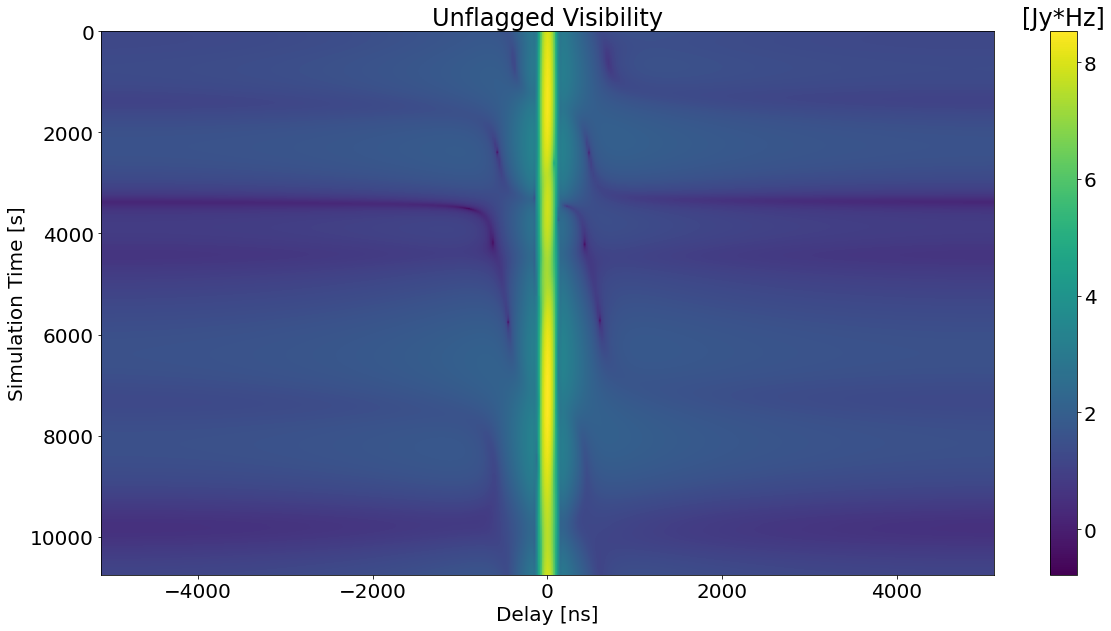

In [24]:
hd = HERAData("data_0.uvh5")
data, flags, nsamples = hd.read()
bh = dspec.gen_window('bh',409)
jul = 24*3600             #julian date to seconds
interpolated_times = (hd.times -hd.times.min())*jul
delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),data.freqs[1] - data.freqs[0]))
ext = (delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min())
ext2 = (data.freqs[0]/1e6, data.freqs[-1]/1e6, interpolated_times.max(), interpolated_times.min())
plt.imshow(np.log10(np.abs(fft(bh*(data[(0,1,'nn')]*(data.freqs[1]-data.freqs[0]))))), extent=ext, aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('[Jy*Hz]')
plt.title('Unflagged Visibility')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')

Text(0, 0.5, 'Simulation Time [s]')

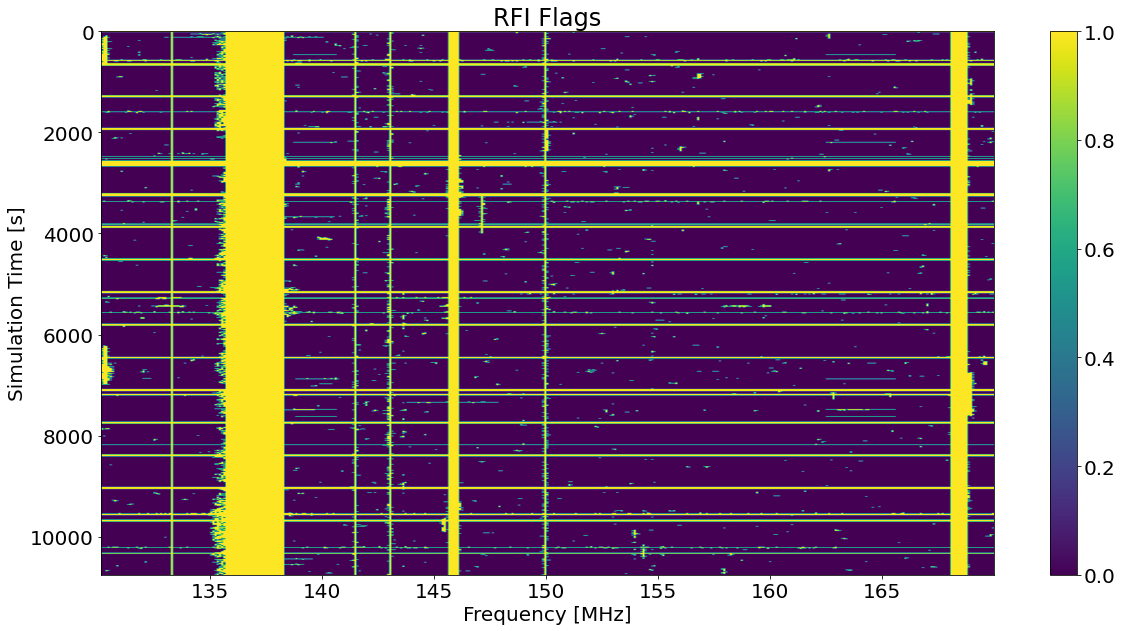

In [20]:
plt.imshow(flags[(0,1,'nn')].astype(float), extent=ext2, aspect='auto' )
plt.colorbar()
plt.title("RFI Flags")
plt.xlabel('Frequency [MHz]')
plt.ylabel('Simulation Time [s]')

Casting complex values to real discards the imaginary part


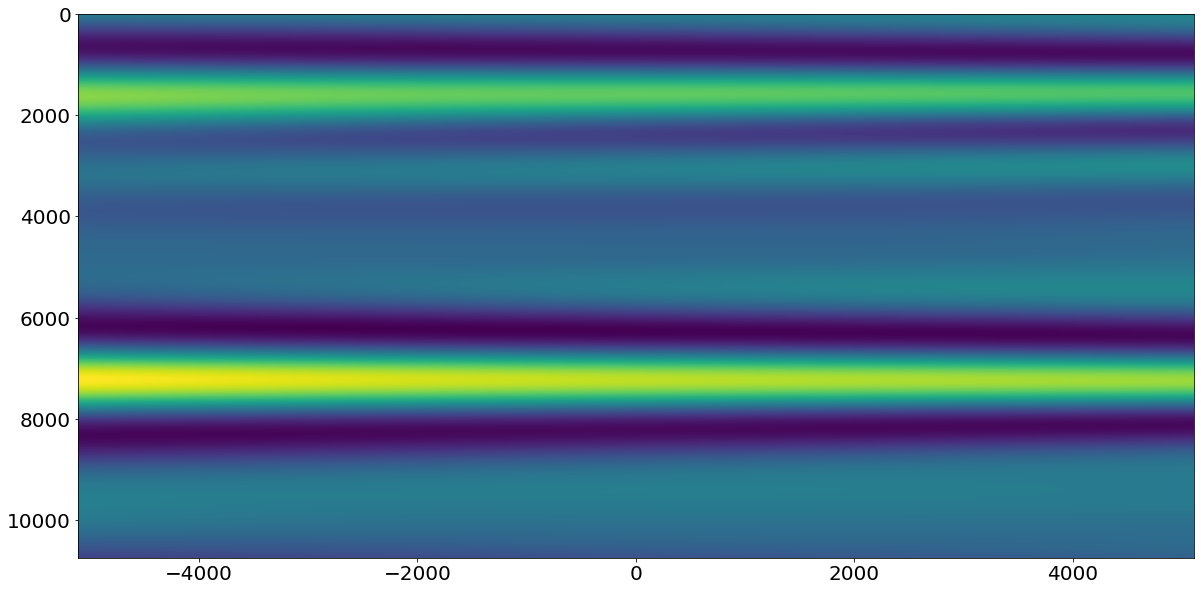

In [24]:
hd = HERAData("data_0.omni_vis.uvh5")
data, flags, nsamples = hd.read()
plt.imshow(data[(0,1,'nn')].astype(float),extent=ext, aspect='auto')

Text(0, 0.5, 'Simulation Time [s]')

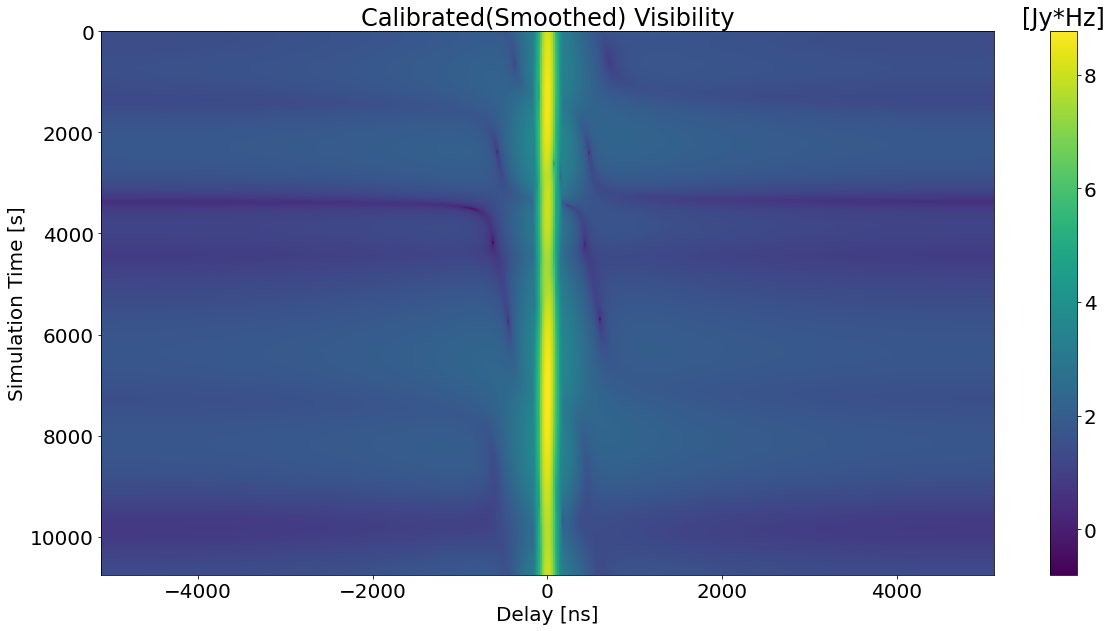

In [29]:
hd = HERAData("data_0_smoothcal.uvh5")
data, flags, nsamples = hd.read()
plt.imshow(np.log10(np.abs(fft(bh*(data[(0,1,'nn')]*(data.freqs[1]-data.freqs[0]))))), extent=ext, aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('[Jy*Hz]')
plt.title('Calibrated(Smoothed) Visibility')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')

divide by zero encountered in log10


Text(0, 0.5, 'Simulation Time [s]')

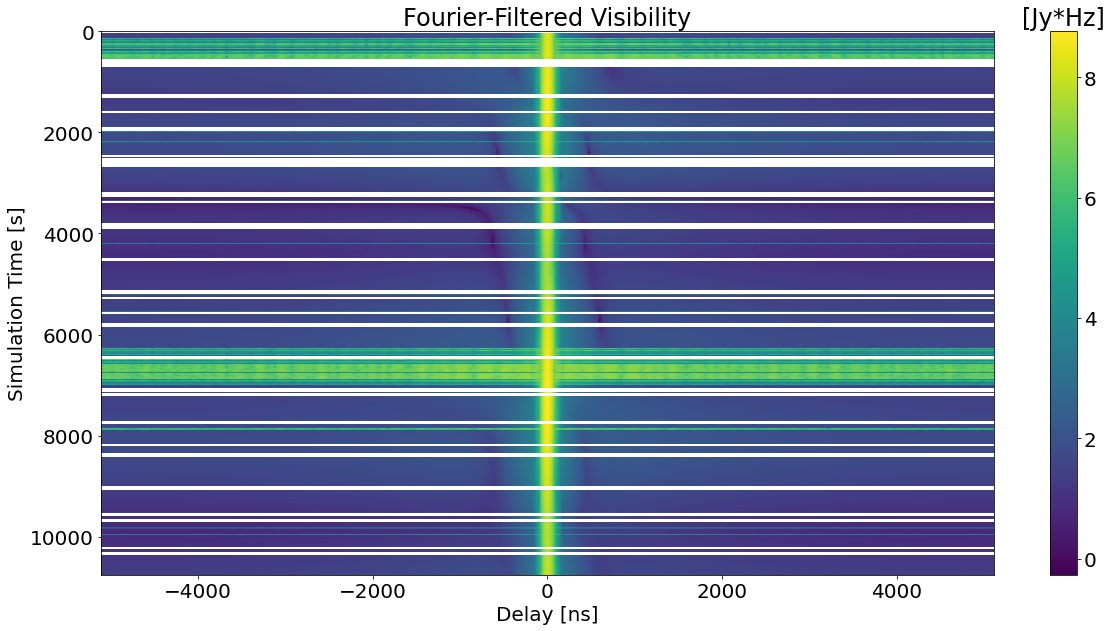

In [30]:
hd = HERAData("data_0_filtered.uvh5")
data, flags, nsamples = hd.read()
plt.imshow(np.log10(np.abs(fft(bh*(data[(0,1,'nn')]*(data.freqs[1]-data.freqs[0]))))), extent=ext, aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('[Jy*Hz]')
plt.title('Fourier-Filtered Visibility')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')

In [8]:
#Comparing Gain Solutions using old redcal_abscal function

for day,flag_file in enumerate(flag_files[0:1]):
    #Opening Data/Flags
    hd_data = HERAData(data_file)    
    hd_model = HERAData(model_file) 
    flags = UVFlag(flag_file)
    flags.select(frequencies = flags.freq_array[(flags.freq_array>=130*1e+6) & (flags.freq_array<=170*1e+6)],
                 times = flags.time_array[3000:4000])
    d_data, d_flags, d_nsamples = hd_data.read()
    m_data, m_flags, m_nsamples = hd_model.read()
    weights = DataContainer({})
    for bl in d_data:
        d_flags[bl] = flags.flag_array.squeeze()
        m_flags[bl] = flags.flag_array.squeeze()
        weights[bl] = (~(d_flags[bl].astype('bool'))).astype(float)
    redcal_flags = {}
    for key in m_flags:
        antkey_xx = (key[0], 'Jxx')
        redcal_flags[antkey_xx] = m_flags[key]
    hd_data.update(flags=d_flags)
    hd_model.update(flags=m_flags)
    hd_data.x_orientation='north'
    hd_model.x_orientation='north'
    hd_data.write_uvh5(f"data_{day}_test.uvh5", clobber=True)
    hd_model.write_uvh5(f"model_{day}_test.uvh5", clobber=True)
    #Calculate Gains/Smooth
    gains = abscal.post_redcal_abscal(copy.deepcopy(d_data),copy.deepcopy(m_data), weights, redcal_flags)
    del d_data,d_flags,d_nsamples,m_data,m_flags,m_nsamples,hd_data,hd_model

File exists; clobbering
File exists; clobbering
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.8971372831593805
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.8331503390299139
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.40153955885685183
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.1863279535564881
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.08646161706980056
...configuring global_phase_slope_logcal for the linfit

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


Text(0.5, 1.0, 'Calibration Solutions , Antenna 0, Snapshot 10')

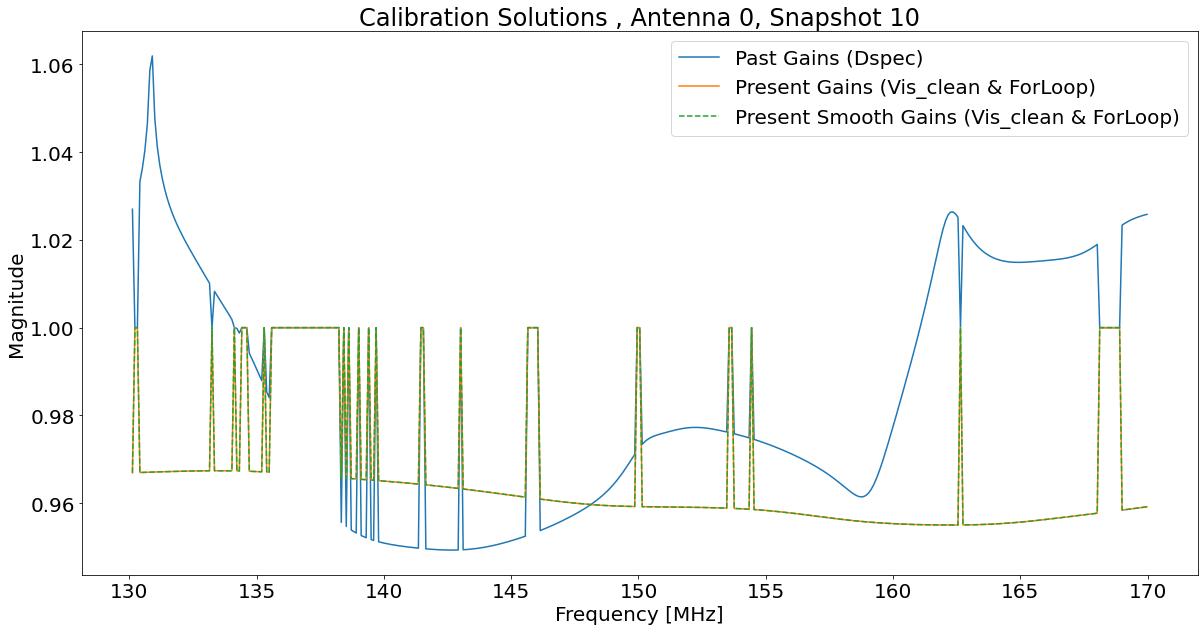

In [9]:
#Gains vs Smooth Gains vs Past Gains (Dpsec)

with open('GAINS/gains_1.pickle', 'rb') as handle:
    gains_past = pickle.load(handle)  
hc = io.HERACal("data_0.abs.calfits")
gains_present, flags, _, _ = hc.read()
hcs = io.HERACal("data_0.smooth_abs.calfits")
gains_smooth_present, flags_smooth, _, _ = hc.read()

plt.plot(data.freqs/1e6, gains_past[(0,'Jxx')][10], label="Past Gains (Dspec)")
plt.plot(data.freqs/1e6, gains_present[(0,'Jnn')][10], label='Present Gains (Vis_clean & ForLoop)')
plt.plot(data.freqs/1e6, gains_smooth_present[(0,'Jnn')][10],ls='--', label='Present Smooth Gains (Vis_clean & ForLoop)')
# plt.plot(data.freqs/1e6, gains[(0,'Jxx')][10], label='Test Gains (Dspec & ForLoop)')
plt.ylabel('Magnitude')
plt.xlabel('Frequency [MHz]')
plt.legend()
plt.title('Calibration Solutions , Antenna 0, Snapshot 10')

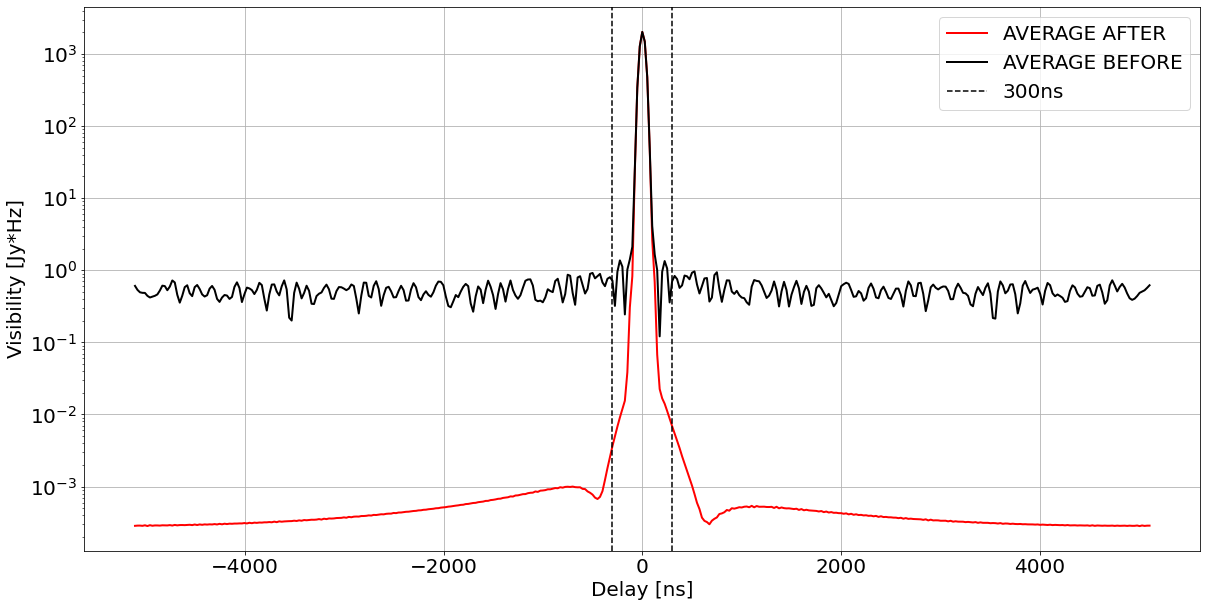

In [31]:
#Averagre Before Filter vs Average After Filter

file = 'data_avg_afterfiltered.uvh5'
hd = HERAData(file)
data_after, flags_after, nsamples_after = hd.read()
file = 'data_avg_beforefiltered.uvh5'
hd = HERAData(file)
data_before, flags_before, nsamples_before = hd.read()


plt.plot(delay_blh*1e+9,fft(bh*(data_after[(0,1,'nn')])[10]), label='AVERAGE AFTER', color='red', linewidth=2)
plt.plot(delay_blh*1e+9,fft(bh*(data_before[(0,1,'nn')])[10]), label='AVERAGE BEFORE', color='black', linewidth=2)
plt.axvline(300,color='black', linestyle='--', label='300ns')
plt.axvline(-300,color='black', linestyle='--')
plt.xlabel('Delay [ns]')
plt.ylabel('Visibility [Jy*Hz]')

plt.yscale('log')
# plt.title('Fourier-Filtered Calibrated Visibility (Residual+Model)')
plt.grid()
plt.legend()

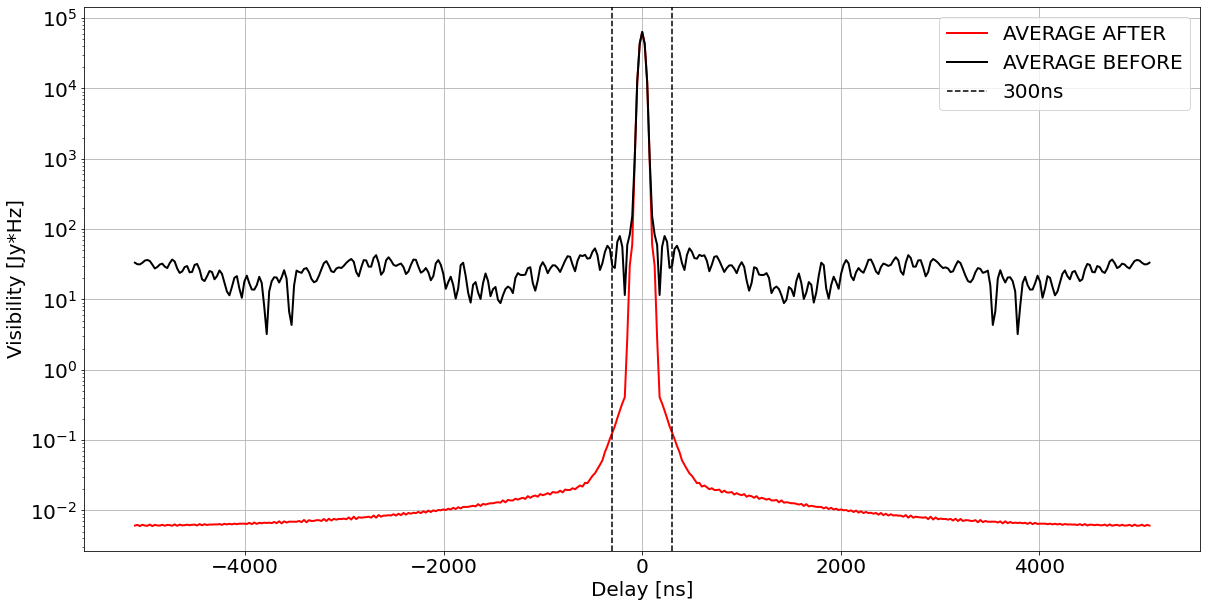

In [32]:
#Average Averages

avg_after = (np.mean(np.abs(data_after[(0,1,'nn')])** 2, axis=0))
avg_before = (np.mean(np.abs(data_before[(0,1,'nn')])** 2, axis=0))


plt.figure()
plt.plot(delay_blh*1e+9,fft(bh*avg_after), label='AVERAGE AFTER', color='red', linewidth=2)
plt.plot(delay_blh*1e+9,fft(bh*avg_before), label='AVERAGE BEFORE', color='black', linewidth=2)
plt.axvline(300,color='black', linestyle='--', label='300ns')
plt.axvline(-300,color='black', linestyle='--')
plt.xlabel('Delay [ns]')
plt.ylabel('Visibility [Jy*Hz]')

plt.yscale('log')
# plt.title('Fourier-Filtered Calibrated Visibility (Residual+Model)')
plt.grid()
plt.legend()

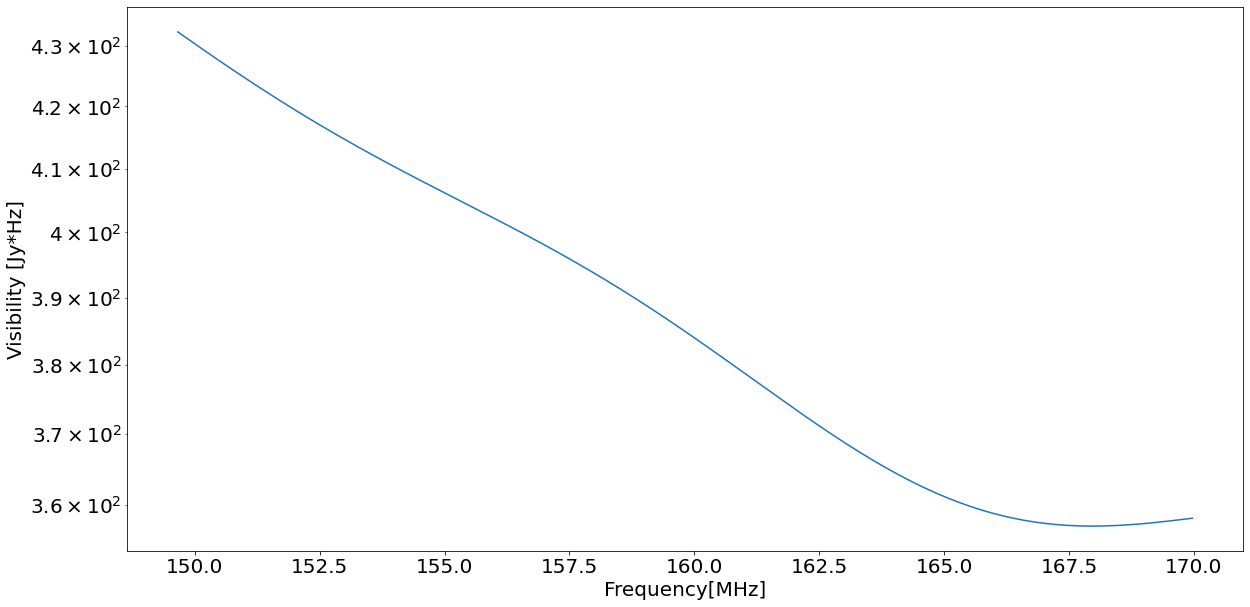

In [49]:
#150-169 MHz

plt.plot(data.freqs[200:409]/1e6, avg_after[200:409], label='AVG AFTER')
plt.ylabel('Visibility [Jy*Hz]')
plt.xlabel('Frequency[MHz]')
plt.yscale('log')

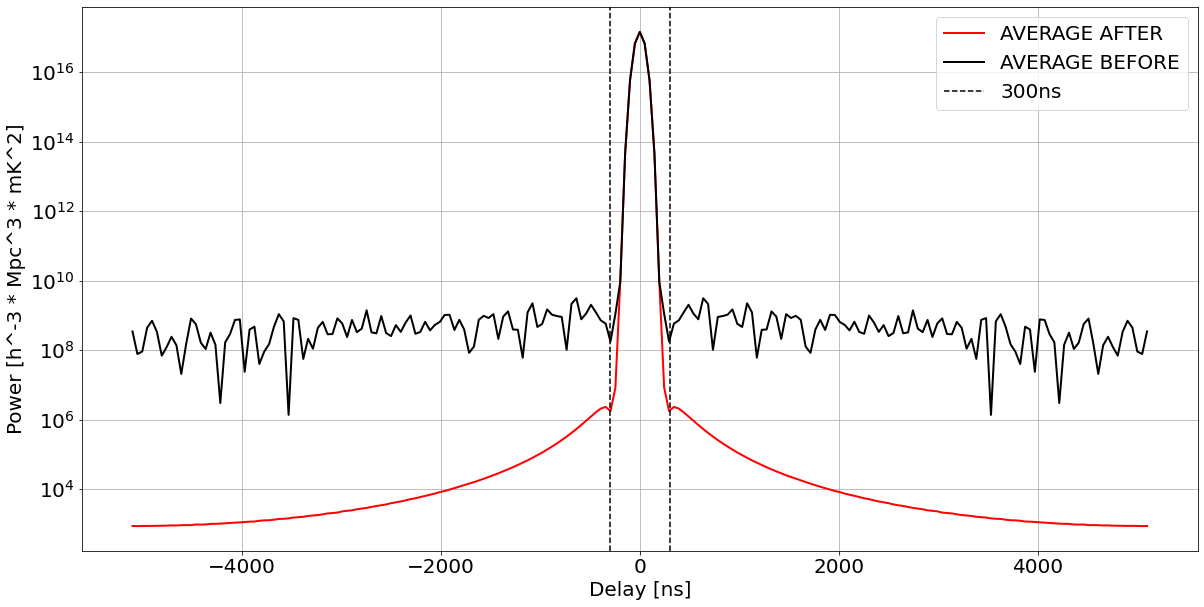

In [13]:
#Average of Average Before/After Fourier-Filtering (150-169MHz)

data.freqs = data.freqs[200:409]
avg_after = avg_after[200:409]
avg_before = avg_before[200:409]
bh = dspec.gen_window('bh',209)
delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),data.freqs[1] - data.freqs[0]))

lambda_obs = 2      #150MHz ---> 2m
lambda_emit = 0.21      #0.21m 
z = (lambda_obs - lambda_emit)/lambda_emit  #z=8.5
X2Y = 540*(((1+z)/10)**(0.9))
B = data.freqs.max()-data.freqs.min()  
d = 14           #14m (diameter of dish)
theta = (1.22*(lambda_obs/d))**2
Omega = np.pi*theta**2
k_b = 1.38e-23  #J/K
Power_Transformation = ((X2Y)/(Omega*B))*(((2*k_b)/(lambda_obs**2))**-2)*(1e-52)


avg_after = fft(bh*avg_after)
avg_before = fft(bh*avg_before)

avg_after = (np.abs(avg_after)**2)*Power_Transformation
avg_before = (np.abs(avg_before)**2)*Power_Transformation


plt.plot(delay_blh*1e+9,(avg_after*1e6)*((data.freqs[1]-data.freqs[0])**2), label='AVERAGE AFTER', color='red', linewidth=2)
plt.plot(delay_blh*1e+9,(avg_before*1e6)*((data.freqs[1]-data.freqs[0])**2), label='AVERAGE BEFORE', color='black', linewidth=2)
plt.axvline(300,color='black', linestyle='--', label='300ns')
plt.axvline(-300,color='black', linestyle='--')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [h^-3 * Mpc^3 * mK^2]')

plt.yscale('log')
# plt.title('Fourier-Filtered Calibrated Visibility (Residual+Model)')
plt.grid()
plt.legend()

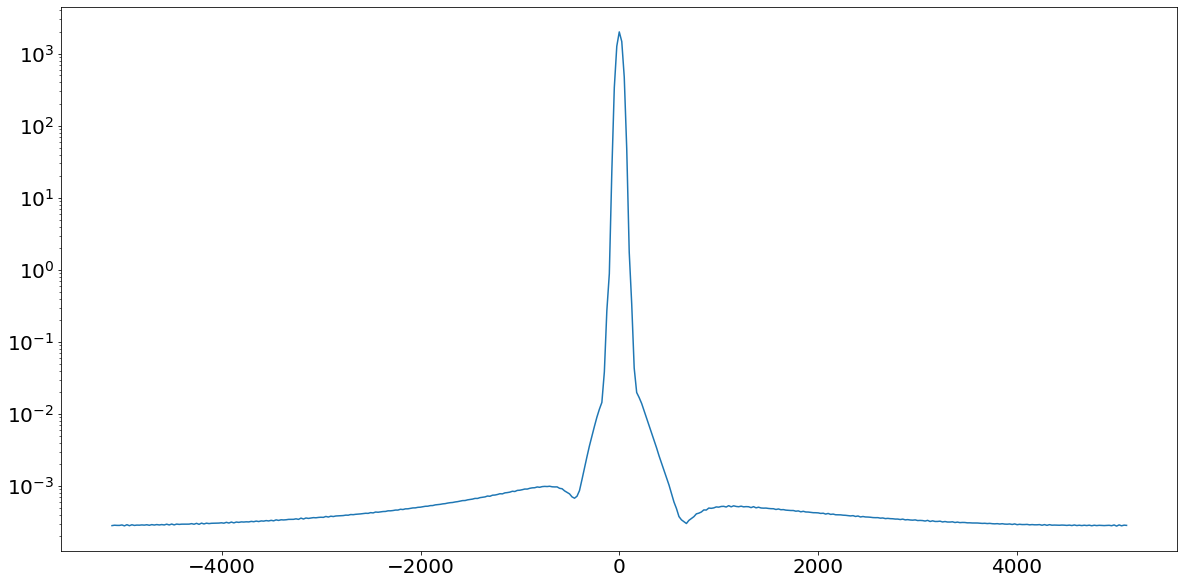

In [48]:
file = f'data_{day}_filtered.uvh5'
hd = HERAData(file)
data,flags,nsmaples = hd.read()
plt.plot(delay_blh*1e+9,fft(bh*data[(0,1,'nn')][10]))
plt.yscale('log')

In [75]:
data

array([         inf,          inf,          inf, 572.78314103,
       572.52591462, 572.26825987, 572.00981287, 571.75011177,
                inf,          inf,          inf,          inf,
                inf,          inf,          inf,          inf,
                inf, 568.97836879,          inf,          inf,
                inf,          inf,          inf,          inf,
                inf,          inf,          inf,          inf,
                inf,          inf,          inf,          inf,
       563.63535671,          inf,          inf,          inf,
                inf,          inf,          inf,          inf,
                inf,          inf,          inf,          inf,
                inf,          inf, 556.72586414, 556.15370756,
       555.57105002, 554.97794147, 554.37444784, 553.76065195,
       553.13665417, 552.50257284, 551.85854432, 551.20472279,
       550.54127956, 549.86840225, 549.1862935 , 548.49516953,
       547.79525846, 547.08679854, 546.37003624, 545.64

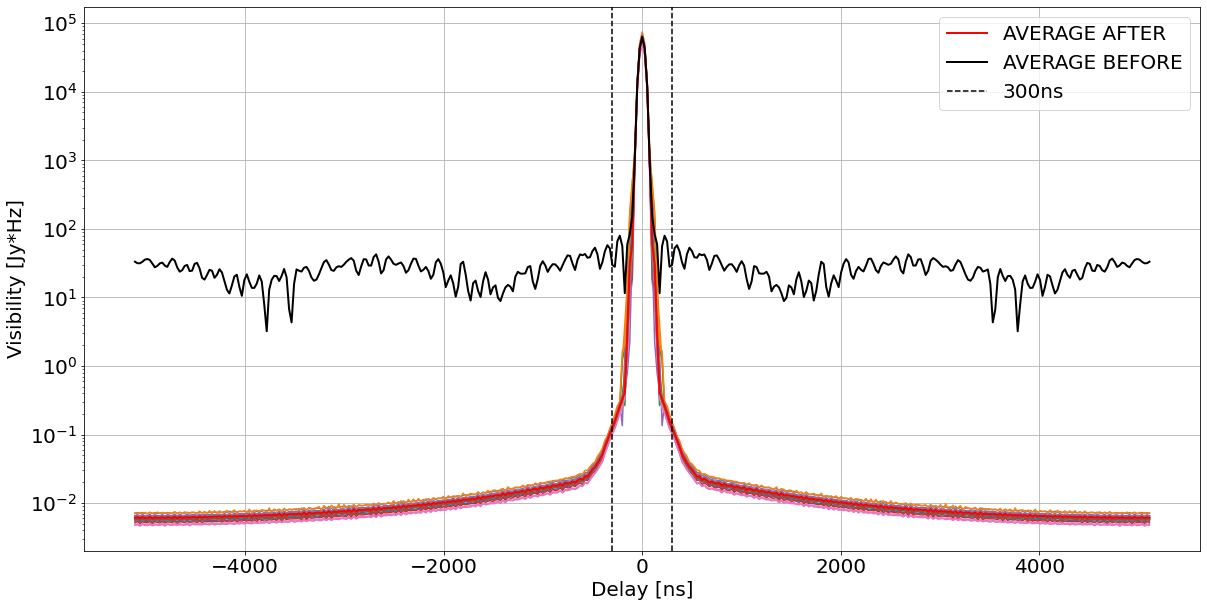

In [77]:
for day in range(18):
    file = f'data_{day}_filtered.uvh5'
    hd = HERAData(file)
    data,flags,nsmaples = hd.read()
    data = np.sum((np.abs(data[(0,1,'nn')])**2)*~flags[(0,1,'nn')], axis=0)/np.sum(~flags[(0,1,'nn')],axis=0)
    plt.plot(delay_blh*1e+9,fft(bh*data))
plt.plot(delay_blh*1e+9,fft(bh*avg_after), label='AVERAGE AFTER', color='red', linewidth=2)
plt.plot(delay_blh*1e+9,fft(bh*avg_before), label='AVERAGE BEFORE', color='black', linewidth=2)
plt.axvline(300,color='black', linestyle='--', label='300ns')
plt.axvline(-300,color='black', linestyle='--')
plt.xlabel('Delay [ns]')
plt.ylabel('Visibility [Jy*Hz]')
plt.yscale('log')
plt.grid()
plt.legend()

In [38]:
file = 'ps_no_halos_z008.46_nf0.581596_useTs1_NX2.0e-01_alphaX1.5_TvirminX2.0e+05_aveTb001 (1).53_Pop2_1024_1600Mpc_v3'
delta_21 = np.loadtxt(file, usecols=1)
k = np.loadtxt(file,usecols=0)

divide by zero encountered in true_divide


Text(0, 0.5, 'Power [h^-3 * Mpc^3 * mK^2]')

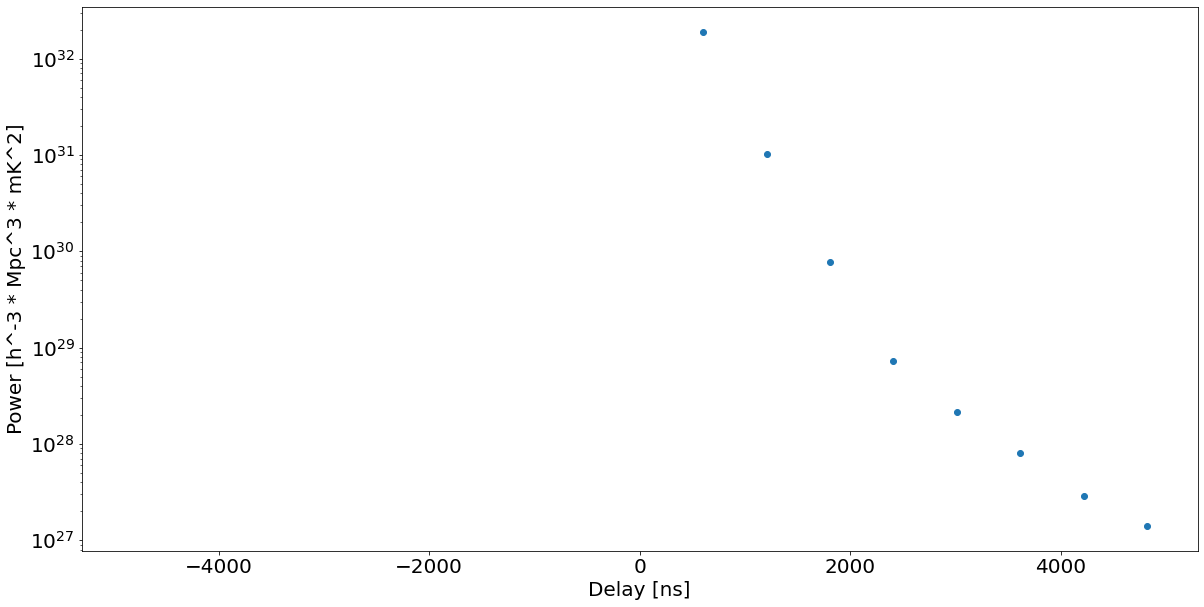

In [69]:
omega = 0.27
Y = 17*((1+z/10)**0.5)*(omega/0.15)**(-0.5)
K = (2*np.pi*delay_blh) / Y 
P = (2*(np.pi**2))/K**3


power_21 = delta_21 * P
plt.plot(delay_blh*1e9, power_21*((data.freqs[1]-data.freqs[0])**2), 'o')
plt.yscale('log')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [h^-3 * Mpc^3 * mK^2]')

In [30]:
from hera_cal import frf
import imp
imp.reload(frf)

<module 'hera_cal.frf' from '/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_cal/frf.py'>

In [13]:
frf.time_avg_data_and_write('data_avg_beforefiltered.uvh5', output_data='data_avg_beforefiltered.Cavg.uvh5',
                            t_avg=300, rephase=True, clobber=True)
frf.time_avg_data_and_write('data_avg_afterfiltered.uvh5', output_data='data_avg_afterfiltered.Cavg.uvh5',
                            t_avg=300, rephase=True, clobber=True)

The t_avg provided of 300.000 has been shifted to 301.280 to make Navg = 28
The t_avg provided of 300.000 has been shifted to 301.280 to make Navg = 28


In [118]:
file_before = 'data_avg_beforefiltered.Cavg.uvh5'
file_after = 'data_avg_afterfiltered.Cavg.uvh5'
avg_before_filter = HERAData(file_before)
avg_after_filter = HERAData(file_after)
avg_bf_data, avg_bf_flags,avg_bf_nsamples = avg_before_filter.read()
avg_af_data, avg_af_flags,avg_af_nsamples = avg_after_filter.read()
airy_beam = pspecbeam.PSpecBeamAiry(diameter=14, freqs=avg_after_filter.freqs)

In [121]:
for k in avg_bf_nsamples:
    if np.all(avg_bf_flags[k]):
        print(k)
    if np.all(avg_bf_nsamples[k]==0):
        print(k)
    if np.any(~np.isfinite(avg_bf_data[k])):
        print(k)

In [117]:
np.any(np.isnan(avg_after_filter.data_array[0]))

False

In [35]:
from hera_pspec import utils as uvp_utils
bls1, bls2, _, _, _, red_groups, _, _ = uvp_utils.calc_blpair_reds(avg_before_filter,avg_before_filter,
                                                                   exclude_auto_bls=True,extra_info=True)

In [46]:
red_antpairs = [[] for m in range(np.max(red_groups)+1)]
for group,bl1,bl2 in zip(red_groups,bls1,bls2):
    red_antpairs[group].append((bl1,bl2))

In [89]:
psd_before = pspecdata.PSpecData(dsets=[avg_before_filter], beam=airy_beam)
psd_before.Jy_to_mK()
psd_after = pspecdata.PSpecData(dsets=[avg_after_filter], beam=airy_beam)
psd_after.Jy_to_mK()

[array([-5])]
[array([-5])]


In [90]:
uvp_before = psd_before.pspec(bls1=bls1,
                              bls2=bls2,
                              taper='bh4', dsets=[0,0],pols=('xx','xx'),
                              allow_fft=True, sampling=True,store_window=False,
                              spw_ranges=[(200,409)])
                              


Setting spectral range: (200, 409)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((0, 15), (1, 16))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (2, 17))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


Casting complex values to real discards the imaginary part



(bl1, bl2) pair: ((0, 15), (3, 18))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (4, 11))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (5, 12))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (6, 13))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (8, 1))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (9, 2))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (10, 3))
pol: (-5, -5)
  Buildin

In [115]:
for blp in uvp_after.get_blpairs():
    key = ((0,blp,('xx','xx')))
    if np.any(np.isnan(uvp_after.get_data(key))):
        print(key)

(0, ((1, 4), (2, 5)), ('xx', 'xx'))
(0, ((1, 4), (3, 6)), ('xx', 'xx'))
(0, ((1, 4), (8, 14)), ('xx', 'xx'))
(0, ((1, 4), (9, 15)), ('xx', 'xx'))
(0, ((1, 4), (10, 16)), ('xx', 'xx'))
(0, ((1, 4), (16, 11)), ('xx', 'xx'))
(0, ((1, 4), (17, 12)), ('xx', 'xx'))
(0, ((1, 4), (18, 13)), ('xx', 'xx'))
(0, ((2, 5), (3, 6)), ('xx', 'xx'))
(0, ((2, 5), (8, 14)), ('xx', 'xx'))
(0, ((2, 5), (9, 15)), ('xx', 'xx'))
(0, ((2, 5), (16, 11)), ('xx', 'xx'))
(0, ((2, 5), (17, 12)), ('xx', 'xx'))
(0, ((2, 5), (18, 13)), ('xx', 'xx'))
(0, ((3, 6), (8, 14)), ('xx', 'xx'))
(0, ((3, 6), (9, 15)), ('xx', 'xx'))
(0, ((3, 6), (10, 16)), ('xx', 'xx'))
(0, ((3, 6), (16, 11)), ('xx', 'xx'))
(0, ((3, 6), (17, 12)), ('xx', 'xx'))
(0, ((3, 6), (18, 13)), ('xx', 'xx'))
(0, ((8, 14), (9, 15)), ('xx', 'xx'))
(0, ((8, 14), (10, 16)), ('xx', 'xx'))
(0, ((8, 14), (16, 11)), ('xx', 'xx'))
(0, ((8, 14), (17, 12)), ('xx', 'xx'))
(0, ((8, 14), (18, 13)), ('xx', 'xx'))
(0, ((9, 15), (10, 16)), ('xx', 'xx'))
(0, ((9, 15), (16, 

In [113]:
uvp_after = psd_after.pspec(bls1=bls1,
                              bls2=bls2,
                              taper='bh4', dsets=[0,0],pols=('xx','xx'),
                              allow_fft=True, sampling=True,store_window=False,
                              spw_ranges=[(200,409)])
                              


Setting spectral range: (200, 409)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((0, 15), (1, 16))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (2, 17))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


Casting complex values to real discards the imaginary part



(bl1, bl2) pair: ((0, 15), (3, 18))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (4, 11))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (5, 12))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (6, 13))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (8, 1))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (9, 2))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (10, 3))
pol: (-5, -5)
  Buildin

invalid value encountered in log10
invalid value encountered in log10


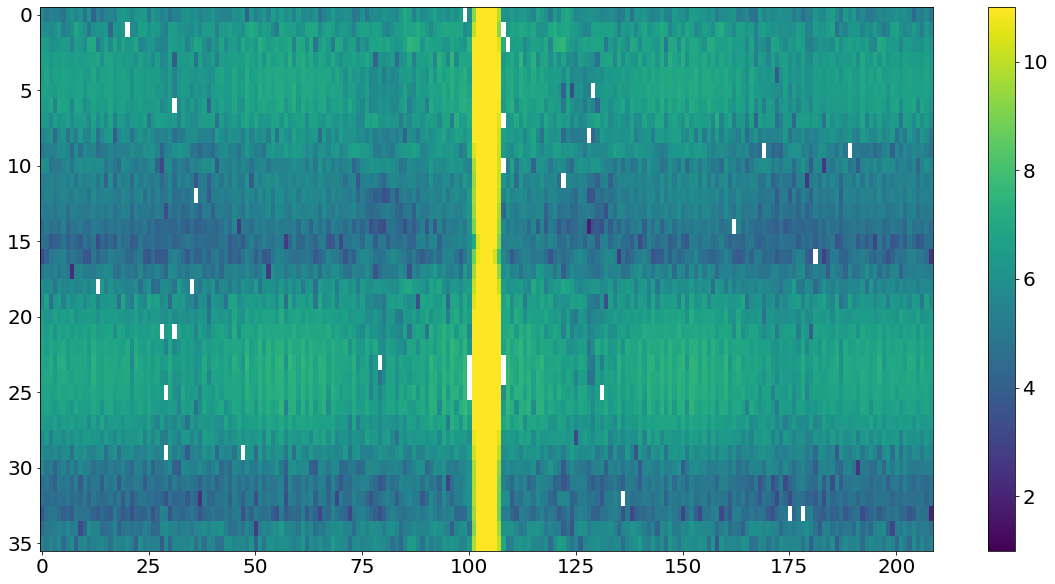

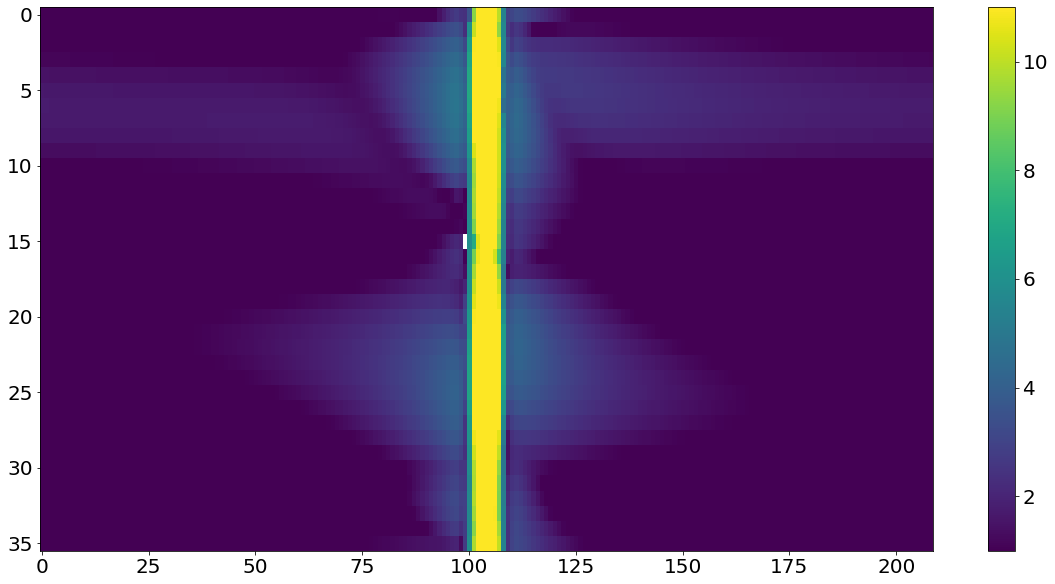

In [92]:
plt.imshow(np.log10(uvp_before.get_data((0,((0,15),(1,16)),('xx','xx'))).real), aspect='auto', vmin=1, vmax=11)
plt.colorbar()
plt.figure()
plt.imshow(np.log10(uvp_after.get_data((0,((0,15),(1,16)),('xx','xx'))).real), aspect='auto', vmin=1, vmax=11)
plt.colorbar()

In [93]:
uvp_before.average_spectra(time_avg=True,blpair_groups=red_antpairs)

In [94]:
uvp_after.average_spectra(time_avg=True,blpair_groups=red_antpairs)

In [95]:
from hera_pspec import plot as pspec_plot

(0.0, 1.0)

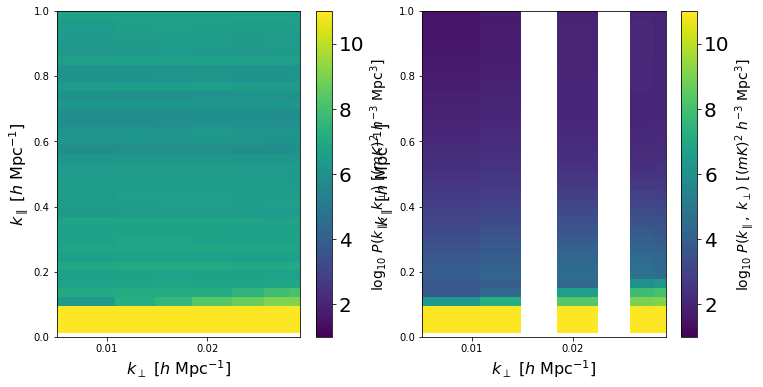

In [96]:
fig,axarray = plt.subplots(1,2)
fig.set_size_inches(12,6)
plt.sca(axarray[0])
handle =pspec_plot.delay_wedge(uvp_before,spw=0,pol=('xx','xx'),fold=True,rotate=True, colorbar=True,
                               vmin=1,vmax=11, ax=axarray[0], delay=False)
plt.gca().set_ylim(0,1)
plt.sca(axarray[1])
handle = pspec_plot.delay_wedge(uvp_after,spw=0,pol=('xx','xx'),fold=True,rotate=True, colorbar=True,
                               vmin=1,vmax=11, ax=axarray[1], delay=False)
plt.gca().set_ylim(0,1)


In [97]:
from hera_pspec import grouping

In [98]:
k_data = uvp_before.get_kparas(0)[104::2]
k_bins = np.diff(k_data)

In [114]:
np.any(np.isnan(uvp_after.data_array[0]))

True

In [99]:
uvp_before_sph = grouping.spherical_average(uvp_in=uvp_before,kbins=k_data[:-1], bin_widths=k_bins)

In [100]:
uvp_after_sph = grouping.spherical_average(uvp_in=uvp_after,kbins=k_data[:-1], bin_widths=k_bins)

In [101]:
uvp_after_sph.get_blpairs()

[((0, 15), (1, 16))]

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


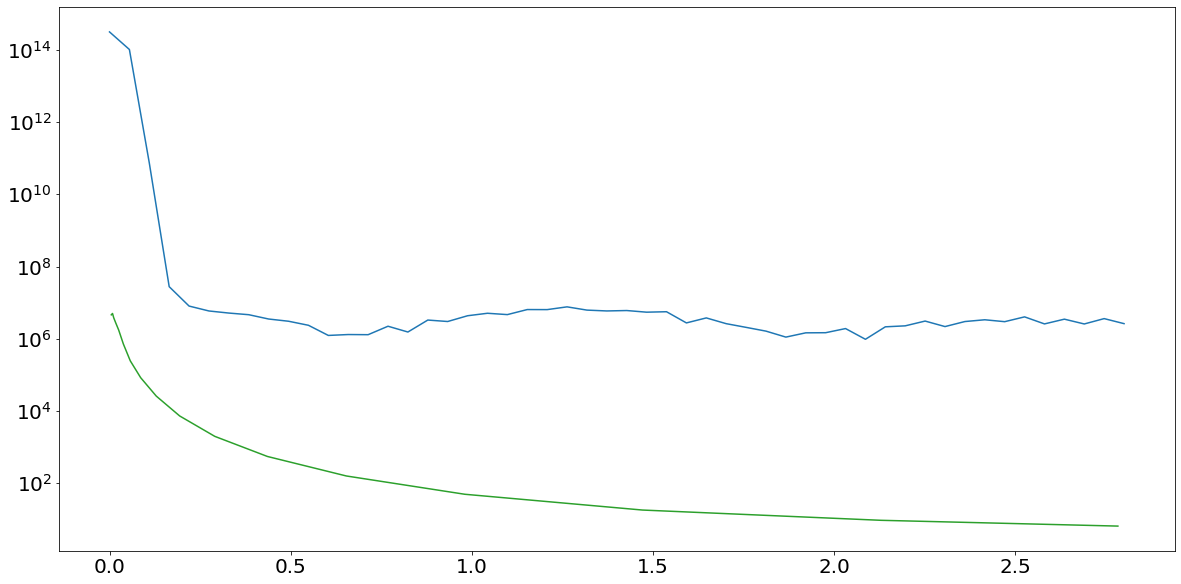

In [105]:
plt.plot(k_data[:-1], uvp_before_sph.get_data((0, ((0, 15), (1, 16)), ('xx', 'xx')))[0])
plt.plot(k_data[:-1], uvp_after_sph.get_data((0, ((0, 15), (1, 16)), ('xx', 'xx')))[0])
plt.plot(k,delta_21/k**3*2*np.pi**2)
plt.yscale('log')

In [103]:
uvp_after_sph.get_data((0, ((0, 15), (1, 16)), ('xx', 'xx')))[0]

array([nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj])

Text(0, 0.5, 'Simulation Time [s]')

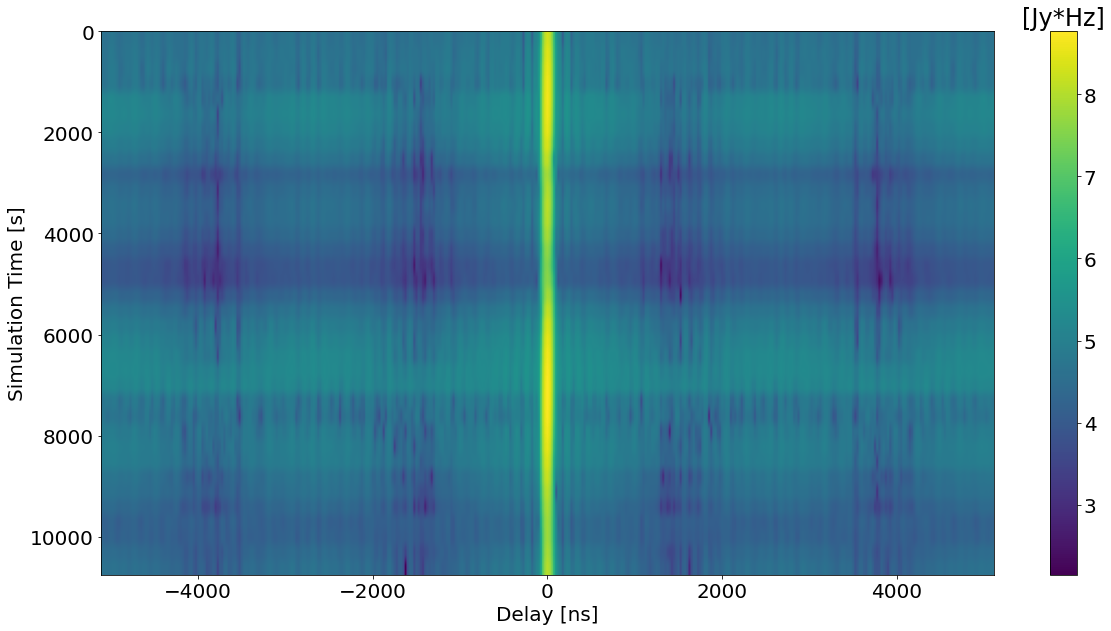

In [25]:
hd = HERAData("data_avg_beforefiltered.fixed.Cavg.uvh5")
data_avgb, flags_avgb, nsamples_avgb = hd.read()
plt.imshow(np.log10(np.abs(fft(bh*(data_avgb[(0,1,'nn')]*(data.freqs[1]-data.freqs[0]))))), extent=ext, aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('[Jy*Hz]')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')

Text(0, 0.5, 'Simulation Time [s]')

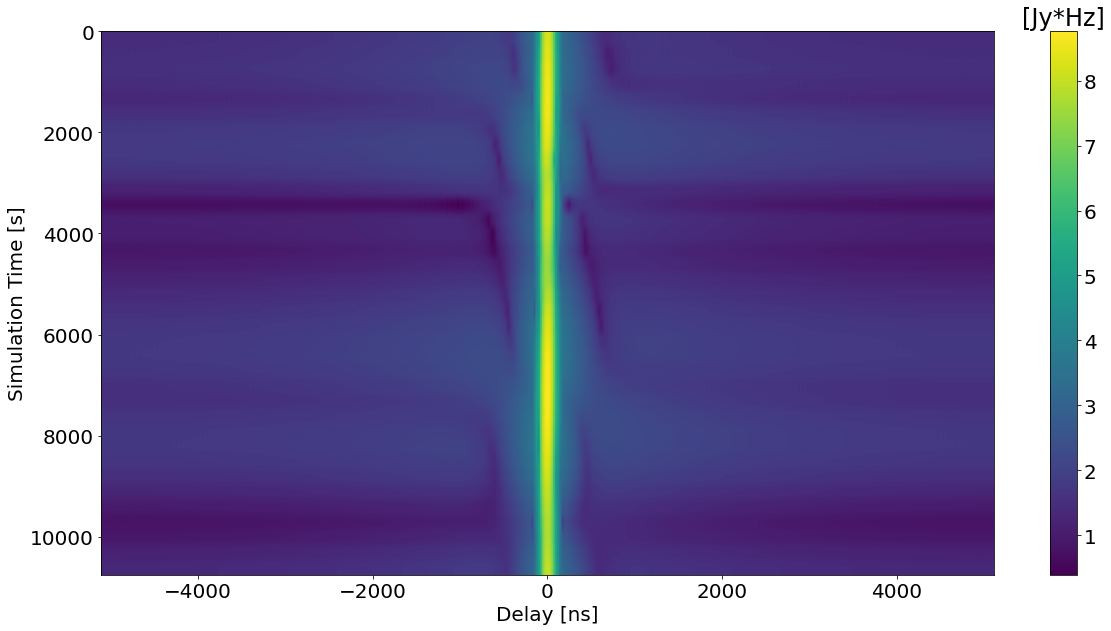

In [26]:
hd = HERAData("data_avg_afterfiltered.fixed.Cavg.uvh5")
data_avga, flags_avga, nsamples_avga = hd.read()
plt.imshow(np.log10(np.abs(fft(bh*(data_avga[(0,1,'nn')]*(data.freqs[1]-data.freqs[0]))))), extent=ext, aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('[Jy*Hz]')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')

In [65]:
file_before = 'data_avg_beforefiltered.fixed.Cavg.uvh5'
file_after = 'data_avg_afterfiltered.fixed.Cavg.uvh5'
avg_before_filter = HERAData(file_before)
avg_after_filter = HERAData(file_after)
avg_bf_data, avg_bf_flags,avg_bf_nsamples = avg_before_filter.read()
avg_af_data, avg_af_flags,avg_af_nsamples = avg_after_filter.read()
airy_beam = pspecbeam.PSpecBeamAiry(diameter=14, freqs=avg_after_filter.freqs)




# for k in avg_bf_nsamples:
#     if np.all(avg_bf_flags[k]):
#         print(k)
#     if np.all(avg_bf_nsamples[k]==0):
#         print(k)
#     if np.any(~np.isfinite(avg_bf_data[k])):
#         print(k)
        
        
from hera_pspec import utils as uvp_utils
bls1, bls2, _, _, _, red_groups, _, _ = uvp_utils.calc_blpair_reds(avg_before_filter,avg_before_filter,
                                                                   exclude_auto_bls=True,extra_info=True)


red_antpairs = [[] for m in range(np.max(red_groups)+1)]
for group,bl1,bl2 in zip(red_groups,bls1,bls2):
    red_antpairs[group].append((bl1,bl2))
    
    
psd_before = pspecdata.PSpecData(dsets=[avg_before_filter], beam=airy_beam)
psd_before.Jy_to_mK()
psd_after = pspecdata.PSpecData(dsets=[avg_after_filter], beam=airy_beam)
psd_after.Jy_to_mK()


uvp_before = psd_before.pspec(bls1=bls1,
                              bls2=bls2,
                              taper='bh7', dsets=[0,0],pols=('xx','xx'),
                              allow_fft=True, sampling=True,store_window=False,
                              spw_ranges=[(200,409)])


uvp_after = psd_after.pspec(bls1=bls1,
                              bls2=bls2,
                              taper='bh7', dsets=[0,0],pols=('xx','xx'),
                              allow_fft=True, sampling=True,store_window=False,
                              spw_ranges=[(200,409)])
                              

[array([-5])]
[array([-5])]

Setting spectral range: (200, 409)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((0, 15), (1, 16))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (2, 17))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (3, 18))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (4, 11))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (5, 12))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (6, 13))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spect

invalid value encountered in log10
invalid value encountered in log10


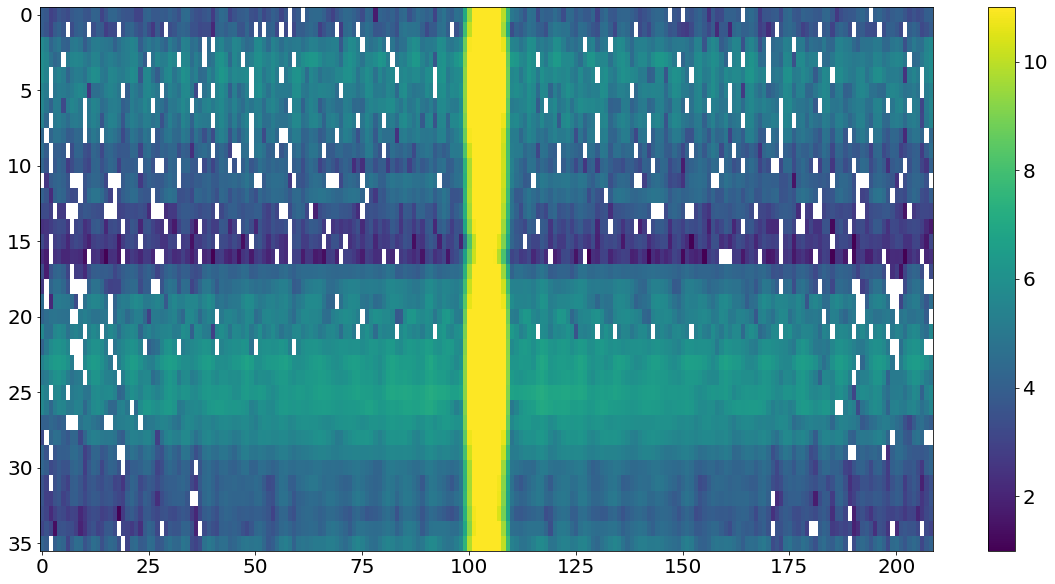

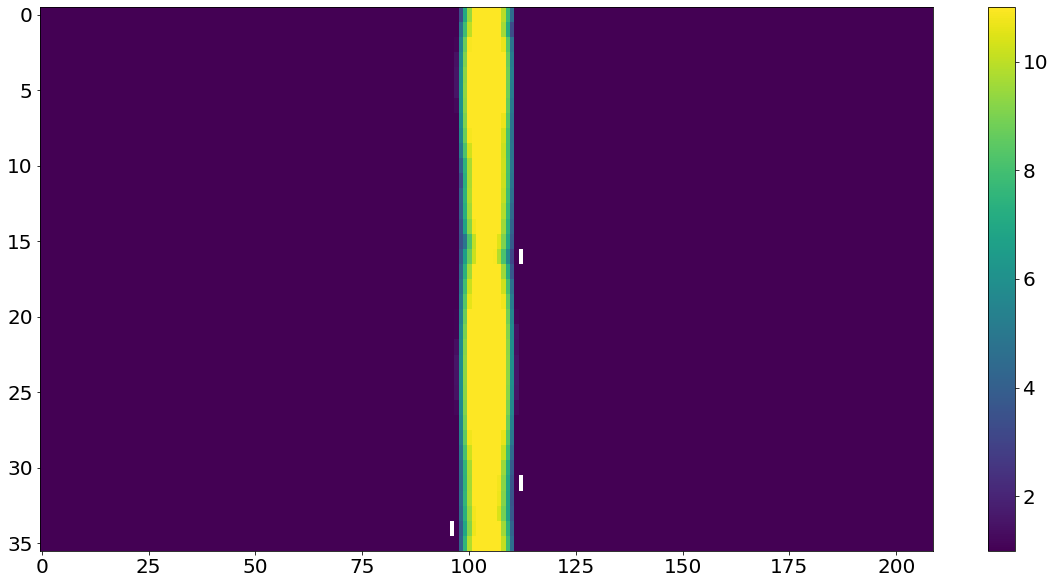

In [66]:
plt.imshow(np.log10(uvp_before.get_data((0,((0,15),(1,16)),('xx','xx'))).real), aspect='auto', vmin=1, vmax=11)
plt.colorbar()
plt.figure()
plt.imshow(np.log10(uvp_after.get_data((0,((0,15),(1,16)),('xx','xx'))).real), aspect='auto', vmin=1, vmax=11)
plt.colorbar()

In [ ]:
#select 

In [67]:
uvp_before.average_spectra(time_avg=True,blpair_groups=red_antpairs)
uvp_after.average_spectra(time_avg=True,blpair_groups=red_antpairs)

In [68]:
from hera_pspec import plot as pspec_plot

(0.0, 1.0)

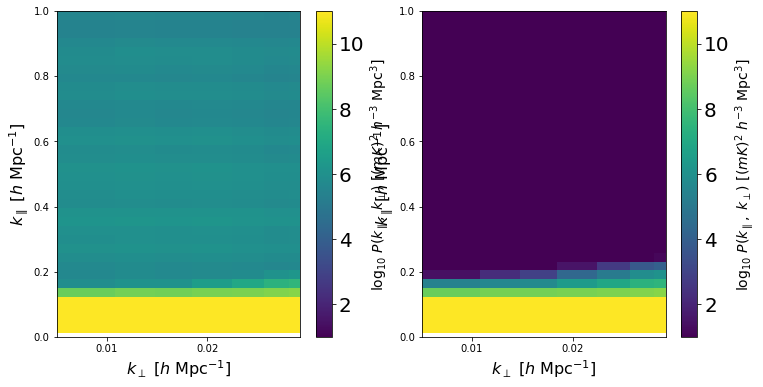

In [69]:
fig,axarray = plt.subplots(1,2)
fig.set_size_inches(12,6)
plt.sca(axarray[0])
handle =pspec_plot.delay_wedge(uvp_before,spw=0,pol=('xx','xx'),fold=True,rotate=True, colorbar=True,
                               vmin=1,vmax=11, ax=axarray[0], delay=False)
plt.gca().set_ylim(0,1)
plt.sca(axarray[1])
handle = pspec_plot.delay_wedge(uvp_after,spw=0,pol=('xx','xx'),fold=True,rotate=True, colorbar=True,
                               vmin=1,vmax=11, ax=axarray[1], delay=False)
plt.gca().set_ylim(0,1)


In [70]:
from hera_pspec import grouping

k_data = uvp_before.get_kparas(0)[104::2]
k_bins = np.diff(k_data)

uvp_before_sph = grouping.spherical_average(uvp_in=uvp_before,kbins=k_data[:-1], bin_widths=k_bins)
uvp_after_sph = grouping.spherical_average(uvp_in=uvp_after,kbins=k_data[:-1], bin_widths=k_bins)

In [71]:
file = 'ps_no_halos_z008.46_nf0.581596_useTs1_NX2.0e-01_alphaX1.5_TvirminX2.0e+05_aveTb001 (1).53_Pop2_1024_1600Mpc_v3'
delta_21 = np.loadtxt(file, usecols=1)
k = np.loadtxt(file,usecols=0)

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


Text(0.5, 0, '$k$ [$hMpc^{-1}$]')

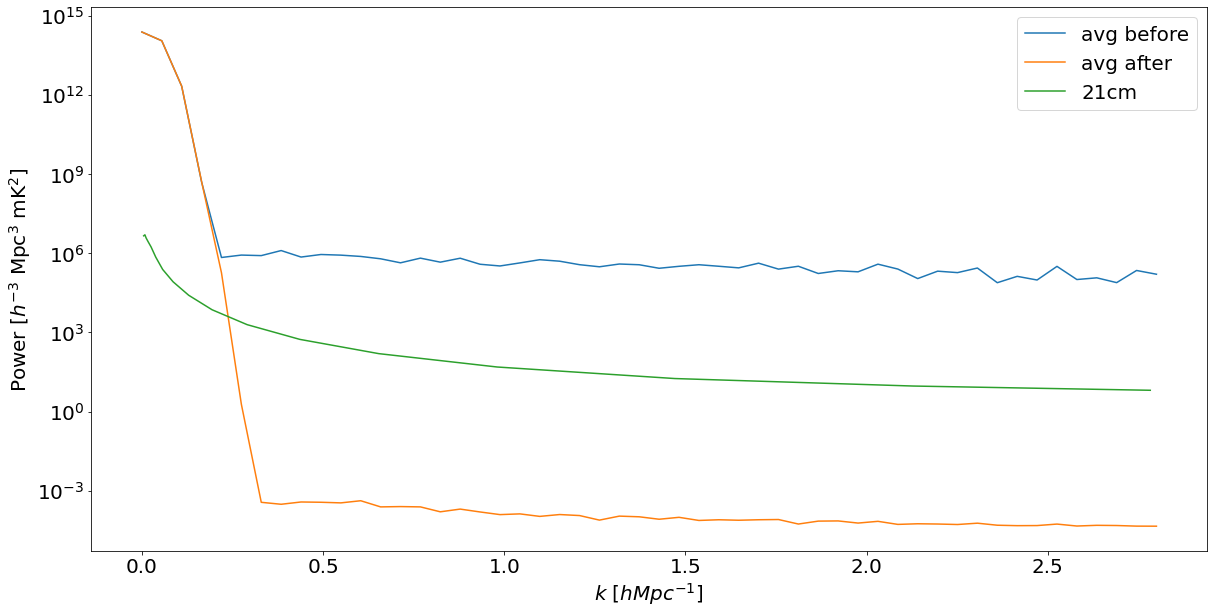

In [85]:
plt.plot(k_data[:-1], uvp_before_sph.get_data((0, ((0, 15), (1, 16)), ('xx', 'xx')))[0], label='avg before')
plt.plot(k_data[:-1], uvp_after_sph.get_data((0, ((0, 15), (1, 16)), ('xx', 'xx')))[0],label='avg after')
plt.plot(k,(delta_21/k**3)*2*np.pi**2, label='21cm')
plt.yscale('log')
plt.legend()
plt.ylabel('Power [$h^{-3}$ Mpc$^3$ mK$^2$]')
plt.xlabel('$k$ [$hMpc^{-1}$]')

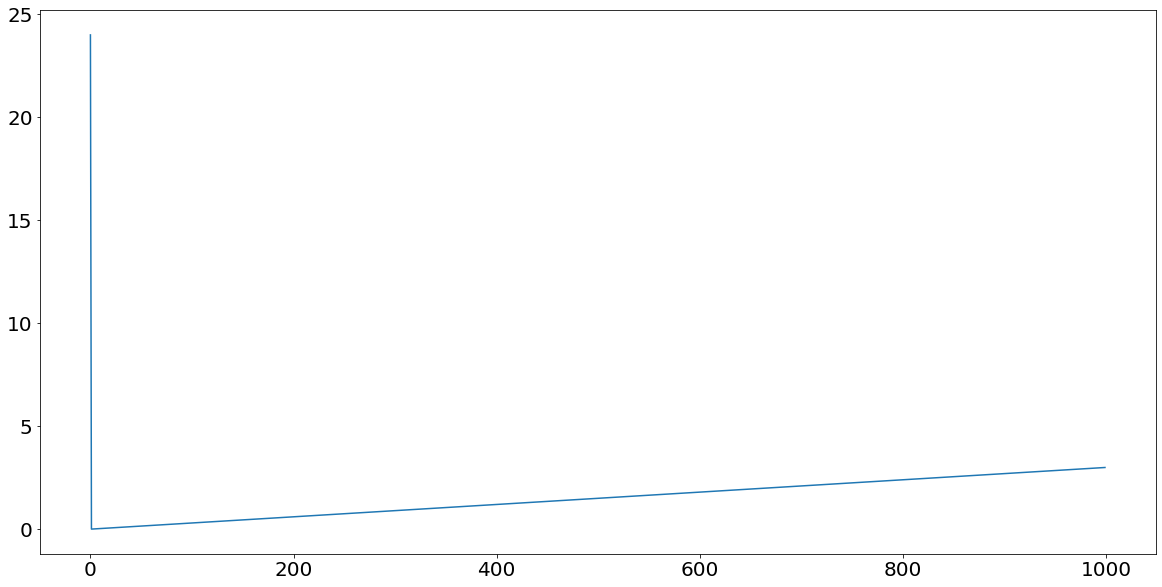

In [76]:
plt.plot(data.lsts*(12/np.pi))

In [79]:
(data.lsts[1:]*(12/np.pi)).max()

2.993942583420264